In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns

# Data

## Bus delay data
Data is from the public transport company in Gdansk. It contains information about the delay of the buses on many lines in Tricity. The data is from 01-01-2023 to 15-01-2025. The data is in the form of csv files. The data is divided into 4 files, so we need to concatenate them. The data contains the following columns:

### Column description
Dzien - day                       
Linia - nr linii                       
Zadanie - połączenie dnia i nr linii                     
Lp przystanku - numer przystanku w kursie             
Przystanek nazwa - nazwa przystanku           
Przystanek numer - unikatowy numer przystanku          
Rozkladowy czas przyjazdu 
Rozkladowy czas odjazdu     
Rzeczywisty czas przyjazdu  
Rzeczywisty czas odjazdu    
Rodzaj detekcji  - serwer/urządzenie w pojeździe - brak opisu

## Stop data  
Data contains information about the stops in Tricity. The data is in the form of json file. 
 The data contains the following columns:

stop_lat - latitude of the stop
stop_lon - longitude of the stop
stop_desc - description of the stop

## Weather data
Data contains information about the weather in Gdansk per day. The data is in the form of csv file. Downloaded from: https://www.visualcrossing.com/
The data contains the following columns:

humidity - humidity
tempmax - max temperature
tempmin - min temperature
precip - precipitation
snowdepth - snow depth
visibility - visibility
datetime - date and time
           

In [14]:
df_202301 = pd.read_csv("do_oddania/20230101-20230531.csv", sep=";")
df_202306 = pd.read_csv("do_oddania/20230601-20231231.csv", sep=";")
df_202401 = pd.read_csv("do_oddania/20240101-20240531.csv", sep=";")
df_202406 = pd.read_csv("do_oddania/20240601-20250115.csv", sep=";")

C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3787337327.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_202301 = pd.read_csv("do_oddania/20230101-20230531.csv", sep=";")
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3787337327.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_202306 = pd.read_csv("do_oddania/20230601-20231231.csv", sep=";")
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3787337327.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_202401 = pd.read_csv("do_oddania/20240101-20240531.csv", sep=";")
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3787337327.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_202406 = pd.read_csv("do_oddania/20240601-20250115.csv", sep=";")


We will first concatenate data and filter it for one bus line.

In [15]:
df = pd.concat([df_202301, df_202306, df_202401, df_202406])
df = df[df["Linia"] == 126]

In [16]:
df.shape

(417172, 11)

# Initial data exploration

In the initial data exploration, we'll check the following:
- missing values
- wrong values
- patterns and trends

This will allow us to clean the data and prepare it for further analysis.

In [17]:
df.head()

Dzien Linia Zadanie  Lp przystanku  \
21359  2023-01-01 00:00:00.000   126  126-01              1   
21360  2023-01-01 00:00:00.000   126  126-01              2   
21361  2023-01-01 00:00:00.000   126  126-01              3   
21362  2023-01-01 00:00:00.000   126  126-01              4   
21363  2023-01-01 00:00:00.000   126  126-01              5   

           Przystanek nazwa  Przystanek numer Rozkladowy czas przyjazdu  \
21359     Banino Borowiecka              7980   2023-01-01 05:24:00.000   
21360         Banino Szkoła              7432   2023-01-01 05:25:00.000   
21361  Rębiechowo PKP (N/Ż)              7430   2023-01-01 05:26:00.000   
21362   Rębiechowo Piaskowa              7428   2023-01-01 05:27:00.000   
21363          Przyrodników              1426   2023-01-01 05:28:00.000   

       Rozkladowy czas odjazdu Rzeczywisty czas przyjazdu  \
21359  2023-01-01 05:24:00.000    2023-01-01 05:39:05.000   
21360  2023-01-01 05:25:00.000    2023-01-01 05:40:30.000   
21361  2023-01-01 05:26:00.000    2023-01-01 05:41:36.000   
21362  2023-01-01 05:27:00.000    2023-01-01 05:42:12.000   
21363  2023-01-01 05:28:00.000    2023-01-01 05:43:20.000   

      Rzeczywisty czas odjazdu  Rodzaj detekcji  
21359  2023-01-01 05:39:38.000                2  
21360  2023-01-01 05:41:07.000                2  
21361  2023-01-01 05:41:46.000                2  
21362  2023-01-01 05:42:26.000                2  
21363  2023-01-01 05:43:55.000                2

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417172 entries, 21359 to 30292725
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Dzien                       417172 non-null  object
 1   Linia                       417172 non-null  object
 2   Zadanie                     417172 non-null  object
 3   Lp przystanku               417172 non-null  int64 
 4   Przystanek nazwa            417172 non-null  object
 5   Przystanek numer            417172 non-null  int64 
 6   Rozkladowy czas przyjazdu   417172 non-null  object
 7   Rozkladowy czas odjazdu     417172 non-null  object
 8   Rzeczywisty czas przyjazdu  399131 non-null  object
 9   Rzeczywisty czas odjazdu    399131 non-null  object
 10  Rodzaj detekcji             417172 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 38.2+ MB


In [7]:
df.Linia.value_counts()

126    417172
Name: Linia, dtype: int64

In [18]:
def transform_date_columns(_df, cols=None):
    if not cols:
        cols  = ['Rozkladowy czas przyjazdu', 'Rozkladowy czas odjazdu', 'Rzeczywisty czas przyjazdu', 'Rzeczywisty czas odjazdu', 'Dzien']
    for c in cols:
        _df[c] = pd.to_datetime(_df[c], errors='coerce')
    return _df

In [19]:
df = transform_date_columns(df)   

## Data coverage

We know that our data is from 01-01-2023 to 15-01-2025. Let's check if we have data for all days in this range.

In [10]:
df["date"] = df["Dzien"].dt
df["year_month"] = df["Dzien"].dt.strftime("%Y-%m")

Text(0, 0.5, 'Number of records [milions]')

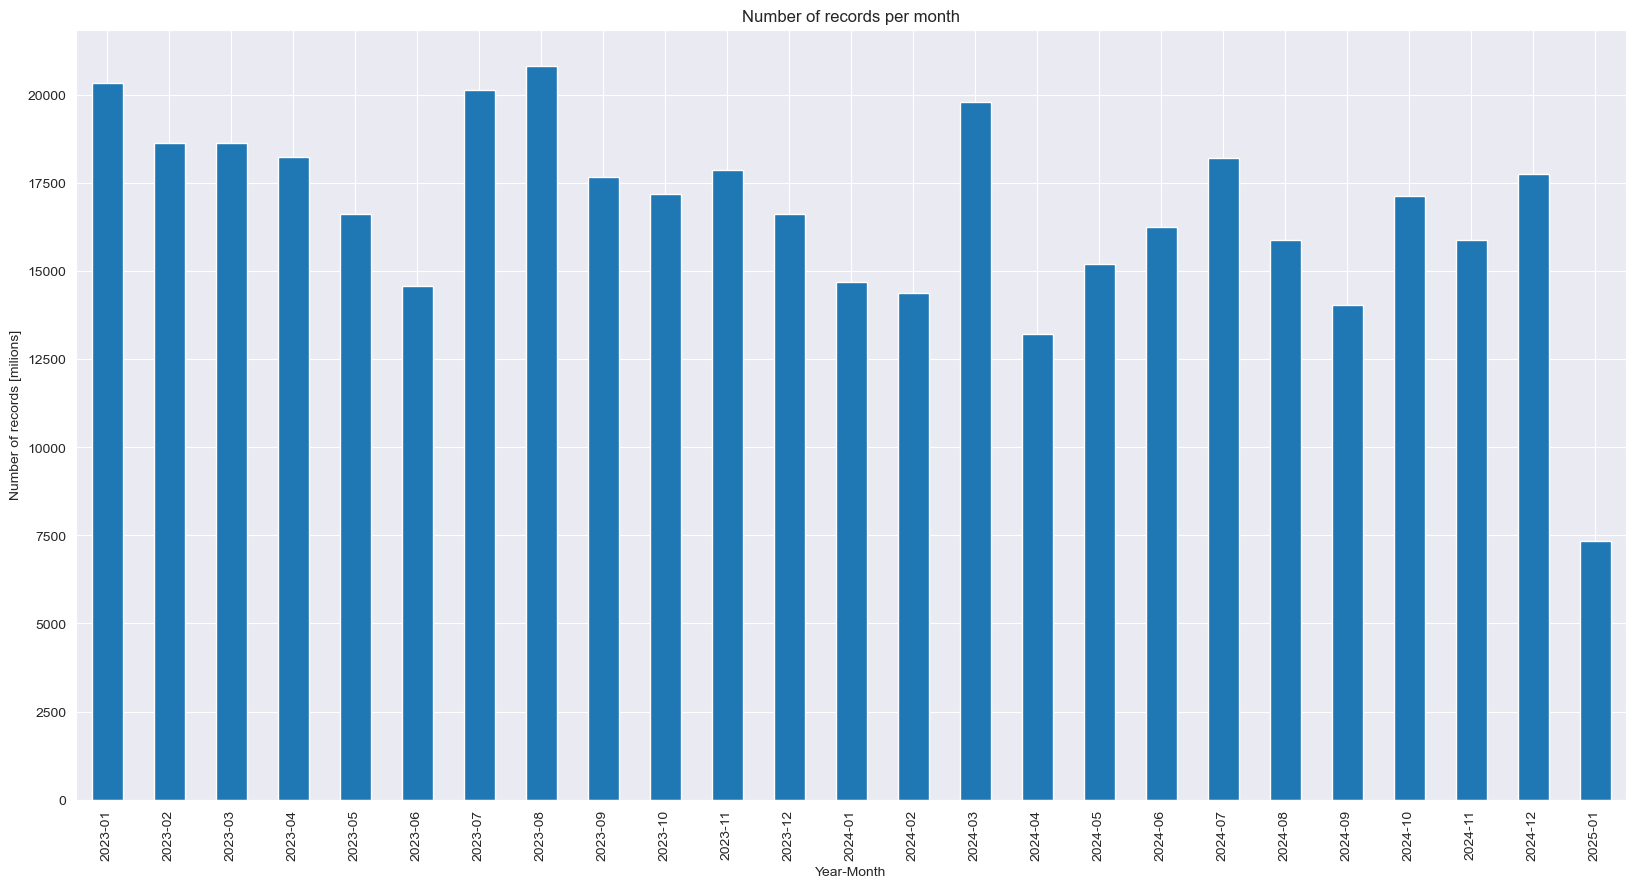

In [11]:
plt.figure(figsize=(20, 10))
df["year_month"].value_counts().sort_index().plot(kind='bar')
plt.title("Number of records per month")
plt.xlabel("Year-Month")
plt.ylabel("Number of records")

In [12]:
df.shape

(417172, 13)

We can see that we have data for all months in the range. The number of records is quite high (400k), so we can be confident that we have a good coverage of the data. Number of data points fluctuates slightly, but it's not a big issue. The last month is not complete due to the time of exporting the data.

## Missing values

We know there are missing values for actual arrival and actual departure time. We know this is due to the following reasons: 
- Driver did not log in
- Device in the vehicle was damaged
- Detours were introduced due to sudden road events
- Delays were so large that the system had trouble matching the correct course (rare cases of really extreme delays of several hundred minutes)
As mentioned by the dataset owner this happens to the full route. We will probably need to drop these rows, as without the actual time, we won't have reliable source of delay information.

In [13]:
missing_values = df.isnull().sum() / df.shape[0] * 100
missing_values

Dzien                         0.000000
Linia                         0.000000
Zadanie                       0.000000
Lp przystanku                 0.000000
Przystanek nazwa              0.000000
Przystanek numer              0.000000
Rozkladowy czas przyjazdu     0.000000
Rozkladowy czas odjazdu       0.000000
Rzeczywisty czas przyjazdu    4.324595
Rzeczywisty czas odjazdu      4.324595
Rodzaj detekcji               0.000000
date                          0.000000
year_month                    0.000000
dtype: float64

We can see that the actual arrival and departure time (values key for calculating delay) are missing in 4% of the cases - it is an acceptable percentage. We'll drop these rows.

## Delay
As mentioned by the dataset owner, the delay is calculated as the difference between the actual arrival time and the scheduled time. In order to accurately calculate the delay:
For the initial stops, we should not take into account the arrival time, and for the final stops - the departure time. Those times can be corrupted. For all stops in between, we can calculate the delay as the difference between the actual arrival time and the scheduled time.

In [14]:
df["Lp przystanku"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

Below, we're creating a short utility function that will allow us to compute just that.

In [21]:
def calculate_delay(row):
    if row["Lp przystanku"] == 1:
        if row["Rzeczywisty czas odjazdu"] <= row["Rozkladowy czas odjazdu"]:
            return -(row["Rozkladowy czas odjazdu"] - row["Rzeczywisty czas odjazdu"])/ np.timedelta64(1, 's')
        else:
            return (row["Rzeczywisty czas odjazdu"] - row["Rozkladowy czas odjazdu"])/ np.timedelta64(1, 's')
    else:
        if row["Rzeczywisty czas przyjazdu"] <= row["Rozkladowy czas przyjazdu"]:
            return -(row["Rozkladowy czas przyjazdu"] - row["Rzeczywisty czas przyjazdu"])/ np.timedelta64(1, 's')
        else:
            return (row["Rzeczywisty czas przyjazdu"] - row["Rozkladowy czas przyjazdu"])/ np.timedelta64(1, 's')

df["delay"] = df[["Lp przystanku", "Rozkladowy czas odjazdu", "Rzeczywisty czas odjazdu", "Rzeczywisty czas przyjazdu", "Rozkladowy czas przyjazdu"]].apply(calculate_delay, axis=1)  

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417172 entries, 21359 to 30292725
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Dzien                       417172 non-null  datetime64[ns]
 1   Linia                       417172 non-null  object        
 2   Zadanie                     417172 non-null  object        
 3   Lp przystanku               417172 non-null  int64         
 4   Przystanek nazwa            417172 non-null  object        
 5   Przystanek numer            417172 non-null  int64         
 6   Rozkladowy czas przyjazdu   417172 non-null  datetime64[ns]
 7   Rozkladowy czas odjazdu     417172 non-null  datetime64[ns]
 8   Rzeczywisty czas przyjazdu  399131 non-null  datetime64[ns]
 9   Rzeczywisty czas odjazdu    399131 non-null  datetime64[ns]
 10  Rodzaj detekcji             417172 non-null  int64         
 11  date                        41717

In [17]:
df.head()

Dzien Linia Zadanie  Lp przystanku      Przystanek nazwa  \
21359 2023-01-01   126  126-01              1     Banino Borowiecka   
21360 2023-01-01   126  126-01              2         Banino Szkoła   
21361 2023-01-01   126  126-01              3  Rębiechowo PKP (N/Ż)   
21362 2023-01-01   126  126-01              4   Rębiechowo Piaskowa   
21363 2023-01-01   126  126-01              5          Przyrodników   

       Przystanek numer Rozkladowy czas przyjazdu Rozkladowy czas odjazdu  \
21359              7980       2023-01-01 05:24:00     2023-01-01 05:24:00   
21360              7432       2023-01-01 05:25:00     2023-01-01 05:25:00   
21361              7430       2023-01-01 05:26:00     2023-01-01 05:26:00   
21362              7428       2023-01-01 05:27:00     2023-01-01 05:27:00   
21363              1426       2023-01-01 05:28:00     2023-01-01 05:28:00   

      Rzeczywisty czas przyjazdu Rzeczywisty czas odjazdu  Rodzaj detekcji  \
21359        2023-01-01 05:39:05      2023-01-01 05:39:38                2   
21360        2023-01-01 05:40:30      2023-01-01 05:41:07                2   
21361        2023-01-01 05:41:36      2023-01-01 05:41:46                2   
21362        2023-01-01 05:42:12      2023-01-01 05:42:26                2   
21363        2023-01-01 05:43:20      2023-01-01 05:43:55                2   

                                                    date year_month  delay  
21359  <pandas.core.indexes.accessors.DatetimePropert...    2023-01  938.0  
21360  <pandas.core.indexes.accessors.DatetimePropert...    2023-01  930.0  
21361  <pandas.core.indexes.accessors.DatetimePropert...    2023-01  936.0  
21362  <pandas.core.indexes.accessors.DatetimePropert...    2023-01  912.0  
21363  <pandas.core.indexes.accessors.DatetimePropert...    2023-01  920.0

### Incorrect / extreme delay values

Field "Detection type" determines which side generated the value to be saved to the database: server or device placed in the vehicle. "As a rule, the device in the vehicle is more reliable. We need to take into account that these data are saved by the system. If we have any suspicions about some of them - we correct them outside the system. It happens rarely, but it happens. One of the reasons may be a problem with the antenna and therefore incorrect data on the vehicle's position, which affects the calculation of the entry/exit time from the stop zone. Or when the vehicle stops at the boundary of the stop zone and "jumps" from the stop and beyond (slight variability in the position calculated by the GPS module)."

We don't have the information which detection type is which, so we'll find that by exploring values of the delay.

- Let's check delay column - we're looking for values larger than hundreds of minutes, so > 600s.
- Let's check if there are any duplicates between the same stop, line and task.


Text(0, 0.5, 'Delay [s]')

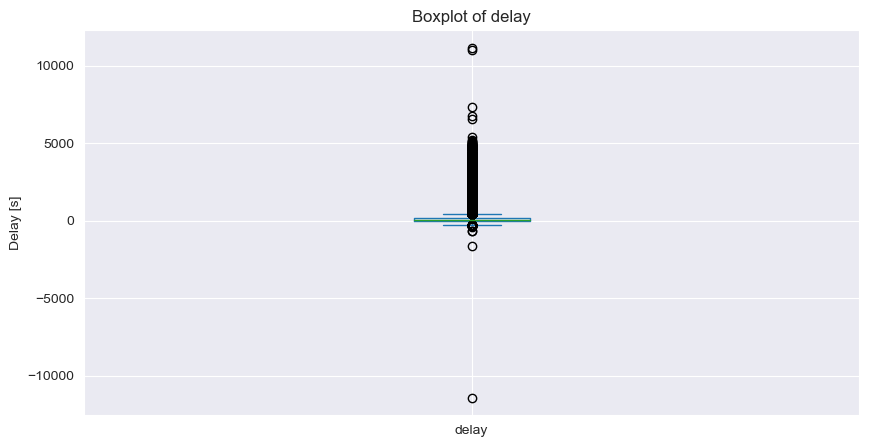

In [18]:
plt.figure(figsize=(10, 5))
df["delay"].plot(kind='box')
plt.title("Boxplot of delay")
plt.ylabel("Delay [s]")

In [19]:
print(f"Percentage of samples with unreasonably high delay {df[df['delay'] > 60 * 60].shape[0] / df.shape[0] * 100}")

Percentage of samples with unreasonably high delay 0.04146970554111973


In [20]:
print(f"Percentage of samples with unreasonably low delay {df[df['delay'] < -60 * 60].shape[0] / df.shape[0] * 100}")


Percentage of samples with unreasonably low delay 0.0002397092805845071


We have 0.1% of samples with unreasonably high and low delay. Let's explore samples that are heavily delayed.

In [21]:
df[df["delay"] > 60 * 60]

Dzien Linia Zadanie  Lp przystanku           Przystanek nazwa  \
2968800  2023-01-24   126  126-07              1  Baza Hallera (techniczny)   
3882972  2023-01-31   126  126-07              1  Baza Hallera (techniczny)   
5720956  2023-02-14   126  126-04              1               Wrzeszcz PKP   
5720957  2023-02-14   126  126-04              2           Galeria Bałtycka   
5720958  2023-02-14   126  126-04              3                  Zabytkowa   
...             ...   ...     ...            ...                        ...   
17848090 2024-10-11   126  126-04             14              Zbieżna (N/Ż)   
17848091 2024-10-11   126  126-04             15            Rakietowa (N/Ż)   
17848092 2024-10-11   126  126-04             16          Kosmonautów (N/Ż)   
17848675 2024-10-11   126  126-06              7           Galeria Bałtycka   
17848676 2024-10-11   126  126-06              8               Wrzeszcz PKP   

          Przystanek numer Rozkladowy czas przyjazdu Rozkladowy czas odjazdu  \
2968800                300       2023-01-24 09:18:00     2023-01-24 09:18:00   
3882972                300       2023-01-31 09:18:00     2023-01-31 09:18:00   
5720956                114       2023-02-14 15:19:00     2023-02-14 15:19:00   
5720957               1383       2023-02-14 15:23:00     2023-02-14 15:23:00   
5720958               1923       2023-02-14 15:27:00     2023-02-14 15:27:00   
...                    ...                       ...                     ...   
17848090              1909       2024-10-11 19:01:00     2024-10-11 19:01:00   
17848091              1415       2024-10-11 19:02:00     2024-10-11 19:02:00   
17848092              1417       2024-10-11 19:03:00     2024-10-11 19:03:00   
17848675              1382       2024-10-11 15:38:00     2024-10-11 15:38:00   
17848676               313       2024-10-11 15:39:00     2024-10-11 15:39:00   

         Rzeczywisty czas przyjazdu Rzeczywisty czas odjazdu  Rodzaj detekcji  \
2968800         2023-01-24 09:16:16      2023-01-24 12:23:47                2   
3882972         2023-01-31 09:22:37      2023-01-31 12:21:26                2   
5720956         2023-02-14 16:22:14      2023-02-14 16:22:19                3   
5720957         2023-02-14 16:29:04      2023-02-14 16:29:05                3   
5720958         2023-02-14 16:36:22      2023-02-14 16:36:24                3   
...                             ...                      ...              ...   
17848090        2024-10-11 20:01:25      2024-10-11 20:01:25                3   
17848091        2024-10-11 20:02:03      2024-10-11 20:02:04                3   
17848092        2024-10-11 20:03:05      2024-10-11 20:03:05                3   
17848675        2024-10-11 16:50:10      2024-10-11 16:50:10                3   
17848676        2024-10-11 16:51:08      2024-10-11 16:51:51                3   

                                                       date year_month  \
2968800   <pandas.core.indexes.accessors.DatetimePropert...    2023-01   
3882972   <pandas.core.indexes.accessors.DatetimePropert...    2023-01   
5720956   <pandas.core.indexes.accessors.DatetimePropert...    2023-02   
5720957   <pandas.core.indexes.accessors.DatetimePropert...    2023-02   
5720958   <pandas.core.indexes.accessors.DatetimePropert...    2023-02   
...                                                     ...        ...   
17848090  <pandas.core.indexes.accessors.DatetimePropert...    2024-10   
17848091  <pandas.core.indexes.accessors.DatetimePropert...    2024-10   
17848092  <pandas.core.indexes.accessors.DatetimePropert...    2024-10   
17848675  <pandas.core.indexes.accessors.DatetimePropert...    2024-10   
17848676  <pandas.core.indexes.accessors.DatetimePropert...    2024-10   

            delay  
2968800   11147.0  
3882972   11006.0  
5720956    3799.0  
5720957    3964.0  
5720958    4162.0  
...           ...  
17848090   3625.0  
17848091   3603.0  
17848092   3605.0  
17848675   4330.0  
17848676   4328.0  

[

(techniczny) - technical stop, the bus is not in passenger service. We should not take into account these stops in the analysis.


In [22]:
extremely_delayed_observations = df[df["delay"] > 60 * 60]
extremely_delayed_observations["Dzien"].value_counts().sort_index()

2023-01-24     1
2023-01-31     1
2023-02-14    11
2023-02-20    22
2023-04-21     1
2023-07-21     1
2023-08-02     1
2023-08-31     8
2023-11-24     4
2023-12-19    44
2023-12-22     1
2024-01-04     7
2024-01-07    20
2024-01-22     2
2024-02-20     1
2024-07-29     8
2024-08-01     1
2024-10-11    39
Name: Dzien, dtype: int64

We can see that the number of extremely delayed observations is quite low and among just a few days. Let's check the distribution of these observations per hour.

Text(0, 0.5, 'Number of observations')

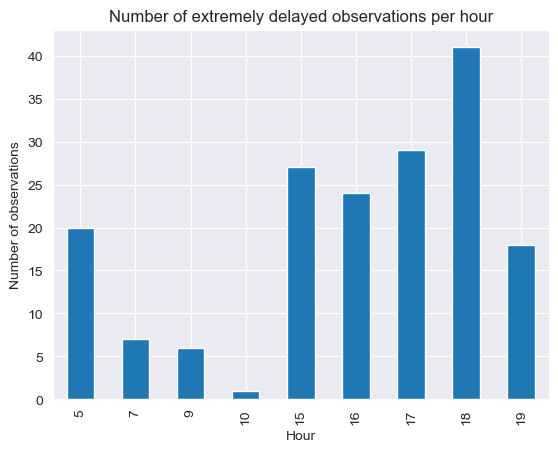

In [23]:
extremely_delayed_observations["Rozkladowy czas przyjazdu"].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title("Number of extremely delayed observations per hour")
plt.xlabel("Hour")
plt.ylabel("Number of observations")

Extreme delays are most common during rush hour 15-18 and at 5 am.

In [24]:
extremely_delayed_observations[extremely_delayed_observations["Rozkladowy czas przyjazdu"].dt.hour == 5]['Zadanie'].value_counts().sort_index()

126-01    20
Name: Zadanie, dtype: int64

At 5 am we have heavy delays for one task only. This could be a technical stop, a broken bus.

Text(0, 0.5, 'Delay [s]')

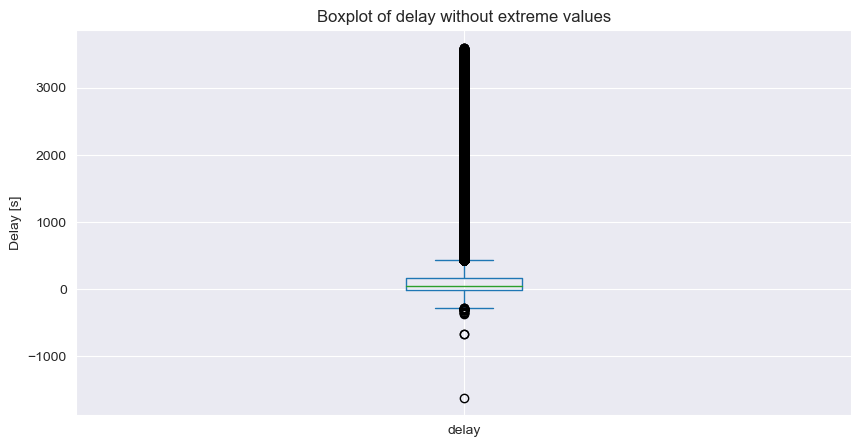

In [25]:
plt.figure(figsize=(10, 5))
df[(df["delay"] < 60 * 60) & (df["delay"] > - 60 *60)]['delay'].plot(kind='box')
plt.title("Boxplot of delay without extreme values")
plt.ylabel("Delay [s]")

It still looks like we have some outliers. However, a bus being 50 minutes late is not uncommon. We'll keep these values for now. For negative delays (bus arriving early) 16 minutes is quite suspicious. Let's see the distribution of delay < 0.

In [26]:
df[df["delay"] < 0]["delay"].describe()


count    124885.000000
mean        -44.152092
std          45.543366
min      -11415.000000
25%         -62.000000
50%         -38.000000
75%         -19.000000
max          -1.000000
Name: delay, dtype: float64

In [27]:
plt.figure(figsize=(10, 5))
df[df["delay"] < -500]["Dzien"].value_counts().sort_index()

2023-02-27    1
2023-03-01    1
2023-07-25    1
2024-11-18    1
Name: Dzien, dtype: int64

<Figure size 1000x500 with 0 Axes>

There are just four days with negative delays smaller than 500 seconds. Let's use -500s (~8 minutes) as our threshold for extreme negative delays. Let's see the distribution of positive delays.

In [28]:
df[df["delay"] >0]["delay"].describe()

count    271090.000000
mean        233.522454
std         369.474142
min           1.000000
25%          44.000000
50%         105.000000
75%         256.000000
max       11147.000000
Name: delay, dtype: float64

From the dataset maintainer we know that values with delay > hundereds of minutes are incorrect. We'll drop these values.

In [29]:
df[(df["delay"] >0) & (df["delay"] < 60*100)]["delay"].describe()

count    271085.000000
mean        233.368888
std         367.635394
min           1.000000
25%          44.000000
50%         105.000000
75%         256.000000
max        5399.000000
Name: delay, dtype: float64

In [30]:
# what % of delays is above 50 minutes
print(f"{df[df['delay'] > 3000].shape[0] / df.shape[0] * 100}% of delays is above 3000s")

0.12848417439329582% of delays is above 3000s


Insights from delay analysis:
- 0.1% of samples have unreasonably high/low delay
- 0.1% of samples have delay above 50 minutes
- very high delays are most common during rush hour 15-18 and happened only on a few days

We'll drop the rows with delay > 3000s and < -500s - those samples are very rare and might skew our model. Let's see the distribution of delay without extreme values.

Text(0.5, 0, 'Delay [s]')

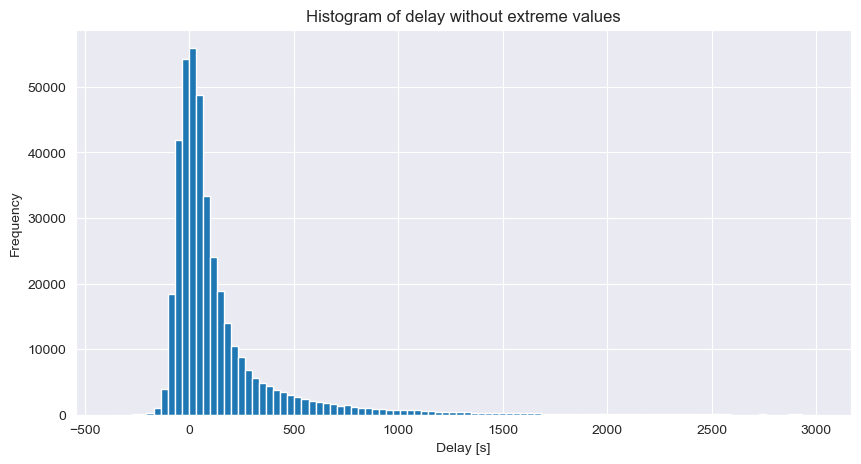

In [31]:
plt.figure(figsize=(10, 5))
df[(df["delay"] < 60 * 50) & (df["delay"] > - 500)]['delay'].plot(kind='hist', bins=100)
plt.title("Histogram of delay without extreme values")
plt.xlabel("Delay [s]")


From the histogram we can see that the distribution of delay is right-skewed. The most common delay is around 0s. We'll drop extreme delay values.

In [22]:
df = df[(df["delay"] < 60 * 50) & (df["delay"] > - 500)]

## Duplicates
Let's verify if our data contains duplicates - defined by a subset of features.

In [23]:
duplicates = df[df.duplicated(subset=["Linia", "Zadanie", "Przystanek numer", "Lp przystanku", "Rozkladowy czas odjazdu"])]
duplicates.shape

(0, 12)

### Looking for trends in delay

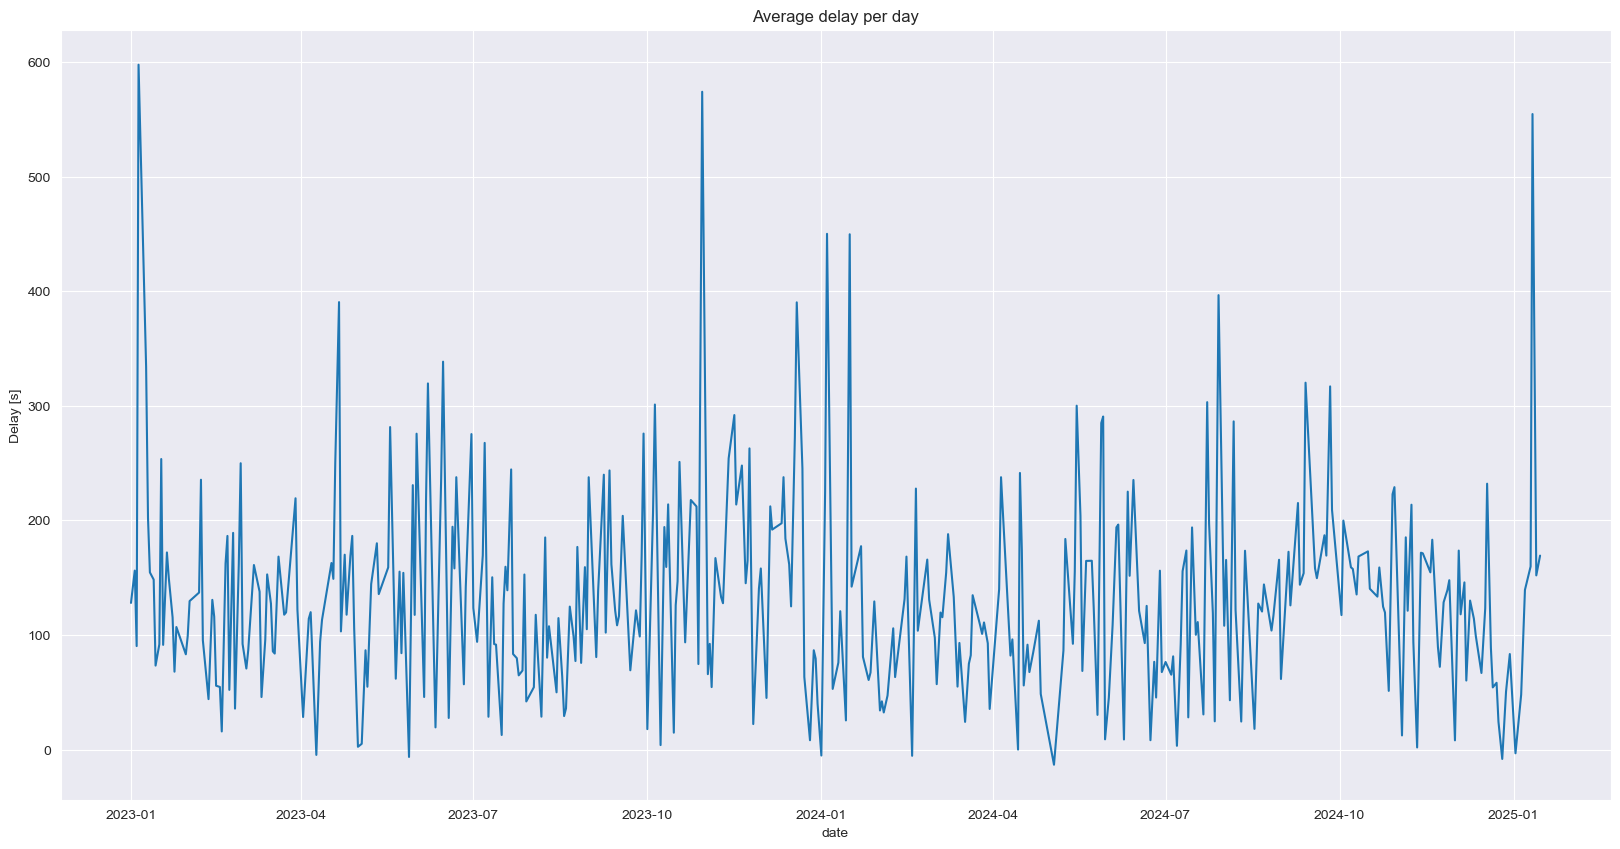

In [34]:
plt.figure(figsize=(20, 10))
df["date"] = df["Dzien"].dt.date
df["delay"].groupby(df["date"]).mean().plot()
plt.title("Average delay per day")
plt.ylabel("Delay [s]")
plt.show()

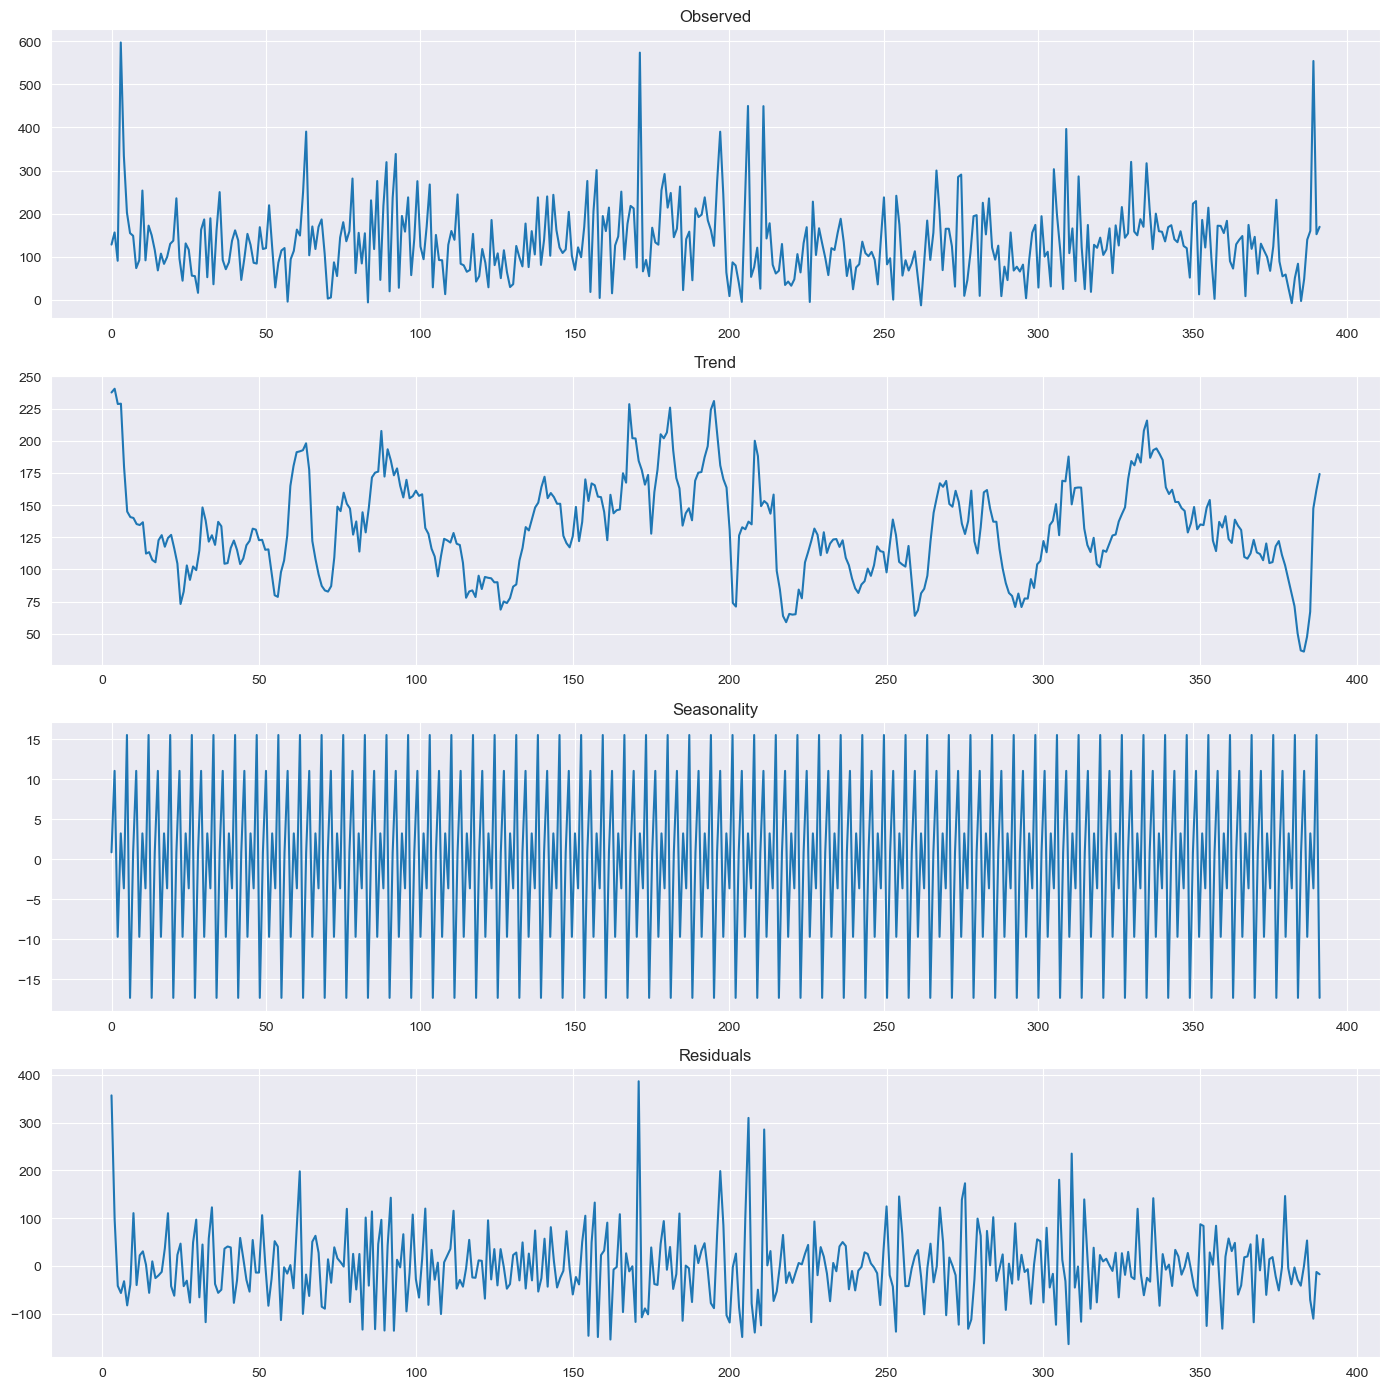

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

average_delay_per_day_df = df["delay"].groupby(df["date"]).mean().reset_index()

result = seasonal_decompose(average_delay_per_day_df["delay"], model="additive", period=7)  # Assuming weekly pattern
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 14))
result.observed.plot(ax=ax1, title="Observed")
result.trend.plot(ax=ax2, title="Trend")
result.seasonal.plot(ax=ax3, title="Seasonality")
result.resid.plot(ax=ax4, title="Residuals")
plt.tight_layout()
plt.show()

Observed:

There are significant spikes around several points, indicating events or outliers with high delays.
The variability seems high throughout the data.

Trend:
A smoother curve shows an underlying pattern in the data.
There's an overall cycle, possibly indicating waves of increasing and decreasing delay averages over time.
Clear dips followed by recoveries might correspond to real-world external factors (such as operational improvements or traffic surges)

Seasonality:
Clear and consistent repetitive patterns indicate strong seasonality.
The amplitude appears relatively stable, suggesting a predictable cyclical component in the data.

Residuals:
These are the random variations after accounting for the trend and seasonality.
Significant spikes suggest outliers or unmodeled noise.
A relatively wide range of residuals shows some unpredictability in the system.


## Adding stop info dataset
We'll connect the stops with the stop information. We'll add stop latitude and longitude, and stop name.

In [26]:
import json
from typing import List, Optional, Dict

class Stop:
    def __init__(self, stopId: int, stopCode: str, stopName: str, stopShortName: str, stopDesc: str,
                 subName: str, date: str, zoneId: int, zoneName: str, virtual: int, nonpassenger: int, depot: int,
                 ticketZoneBorder: int, onDemand: int, activationDate: str, stopLat: float, stopLon: float,
                 stopType: str, stopUrl: str, locationType: Optional[str], parentStation: Optional[str],
                 stopTimezone: Optional[str], wheelchairBoarding: Optional[str]):
        self.stopId = stopId
        self.stopCode = stopCode
        self.stopName = stopName
        self.stopShortName = stopShortName
        self.stopDesc = stopDesc
        self.subName = subName
        self.date = date
        self.zoneId = zoneId
        self.zoneName = zoneName
        self.virtual = virtual
        self.nonpassenger = nonpassenger
        self.depot = depot
        self.ticketZoneBorder = ticketZoneBorder
        self.onDemand = onDemand
        self.activationDate = activationDate
        self.stopLat = stopLat
        self.stopLon = stopLon
        self.stopType = stopType  
        self.stopUrl = stopUrl
        self.locationType = locationType
        self.parentStation = parentStation
        self.stopTimezone = stopTimezone
        self.wheelchairBoarding = wheelchairBoarding

    def __repr__(self):
        return f"Stop({self.stopId}, {self.stopName},{self.stopDesc} {self.stopLat}, {self.stopLon})"


class Data:
    def __init__(self, lastUpdate: str, stops: List[Stop]):
        self.lastUpdate = lastUpdate
        self.stops = stops

    def __repr__(self):
        return f"Data({self.lastUpdate}, {len(self.stops)} stops)"


def load_json_to_objects(file_path: str) -> Dict[int, Stop]:
    with open(file_path, 'r', encoding='utf-8') as f:
        input_data = json.load(f)

    stop_dict = {}

    for date, entry in input_data.items():
        for stop in entry['stops']:
            stop['stopType'] = stop['type']
            del stop['type']
            
            stop_obj = Stop(**stop)
            stop_dict[stop_obj.stopId] = stop_obj

    return stop_dict


file_path = 'D:\PJATK_MGR\projekt\stops.json' 
stop_dict = load_json_to_objects(file_path)


print(stop_dict.get(1024))  # Example: Access stop with stopId 1024`
print(stop_dict.get(1024).stopDesc)
print(len(stop_dict))

Stop(1024, None,Tamka (N/Ż) 54.35912, 18.70535)
Tamka (N/Ż)
2754


In [27]:
def add_stop_info(_df):
    _df['stop_desc'] = _df['Przystanek numer'].apply(
        lambda stop_id: stop_dict.get(stop_id).stopDesc if stop_id in stop_dict else None)
    _df['stop_lat'] = _df['Przystanek numer'].apply(
        lambda stop_id: stop_dict.get(stop_id).stopLat if stop_id in stop_dict else None)
    _df['stop_lon'] = _df['Przystanek numer'].apply(
        lambda stop_id: stop_dict.get(stop_id).stopLon if stop_id in stop_dict else None)
    return _df

In [28]:
df = add_stop_info(df)

C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3559576465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['stop_desc'] = _df['Przystanek numer'].apply(
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3559576465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['stop_lat'] = _df['Przystanek numer'].apply(
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\3559576465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [29]:
df.to_csv("data_with_stop_info_126.csv")

In [36]:
df = pd.read_csv("data_with_stop_info_126.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'Dzien', 'Linia', 'Zadanie', 'Lp przystanku',
       'Przystanek nazwa', 'Przystanek numer', 'Rozkladowy czas przyjazdu',
       'Rozkladowy czas odjazdu', 'Rzeczywisty czas przyjazdu',
       'Rzeczywisty czas odjazdu', 'Rodzaj detekcji', 'delay', 'stop_desc',
       'stop_lat', 'stop_lon'],
      dtype='object')

# Data analysis & prep for modelling

In this part of the analysis we'll create new features and analyze the relationship between features and delay.

In [30]:
from workalendar.europe.poland import Poland

def categorize_time_of_day(hour):
    if 23 <= hour or hour <= 4:
        return 'Night'
    elif 5 <= hour <= 7:
        return 'Early Morning'
    elif 8 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 14:
        return 'Afternoon'
    elif 15 <= hour <= 18:
        return 'Evening'
    else:
        return 'Late Evening'


def prep_df_for_modelling(_df):
    _df = transform_date_columns(_df)
    _df = _df[['Zadanie', "Linia","Lp przystanku", "Rozkladowy czas przyjazdu", "Rodzaj detekcji", "delay", "stop_desc", "stop_lat", "stop_lon"]]
    _df = _df.dropna()
    _df = _df[(_df["delay"] < 40 * 60) & (_df["delay"] > - 40 *60)]
    _df["Rozkladowy_czas_przyjazdu_is_weekday"] = _df["Rozkladowy czas przyjazdu"].dt.weekday < 5
    _df["Rozkladowy_czas_przyjazdu_time_of_day"] = _df["Rozkladowy czas przyjazdu"].dt.hour.apply(categorize_time_of_day)
    holidays = [date[0] for date in Poland().holidays(2024)] + [date[0] for date in Poland().holidays(2025)] + [date[0] for date in Poland().holidays(2023)]
    _df['Rozkladowy_czas_przyjazdu_is_holiday'] = _df["Rozkladowy czas przyjazdu"].dt.date.isin(holidays)
    _df['Rozkladowy_czas_przyjazdu_hour'] = _df["Rozkladowy czas przyjazdu"].dt.hour
    
    return _df

In [31]:
df_for_modelling = prep_df_for_modelling(df)

C:\Users\48514\AppData\Local\Temp\ipykernel_22792\2983957725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[c] = pd.to_datetime(_df[c], errors='coerce')
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\2983957725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[c] = pd.to_datetime(_df[c], errors='coerce')
C:\Users\48514\AppData\Local\Temp\ipykernel_22792\2983957725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [32]:
df_for_modelling.to_csv("df_for_modelling_126.csv")

In [37]:
df_for_modelling = pd.read_csv("df_for_modelling_126.csv")

## Analyzing feature & delay relationship


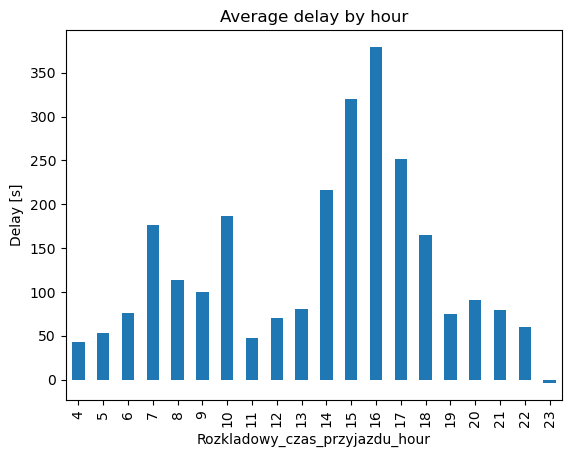

In [33]:
# average delay by hour
df_for_modelling.groupby("Rozkladowy_czas_przyjazdu_hour")["delay"].mean().plot(kind='bar')
plt.title("Average delay by hour")
plt.ylabel("Delay [s]")
plt.show()

We can see that the average delay is the highest at 3-7pm and lowest at 11pm. Higher delay might be explained by increased traffic. Let's explore delay with different features.

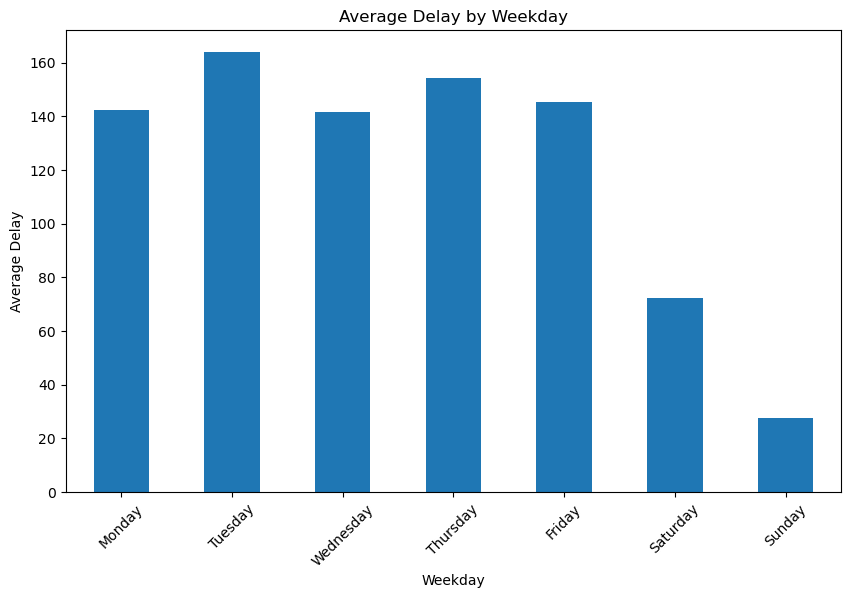

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

df_for_modelling['Rozkladowy czas przyjazdu'] = pd.to_datetime(df_for_modelling['Rozkladowy czas przyjazdu'])  
df_for_modelling['weekday'] = df_for_modelling['Rozkladowy czas przyjazdu'].dt.weekday  
df_for_modelling['day_name'] = df_for_modelling['Rozkladowy czas przyjazdu'].dt.day_name()  

avg_delay_per_weekday = df_for_modelling.groupby('weekday')['delay'].mean()

plt.figure(figsize=(10, 6))
avg_delay_per_weekday.plot(kind='bar')
plt.title('Average Delay by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Delay')
plt.xticks(rotation=45, labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ticks=range(7))
plt.show()


<Figure size 1000x500 with 0 Axes>

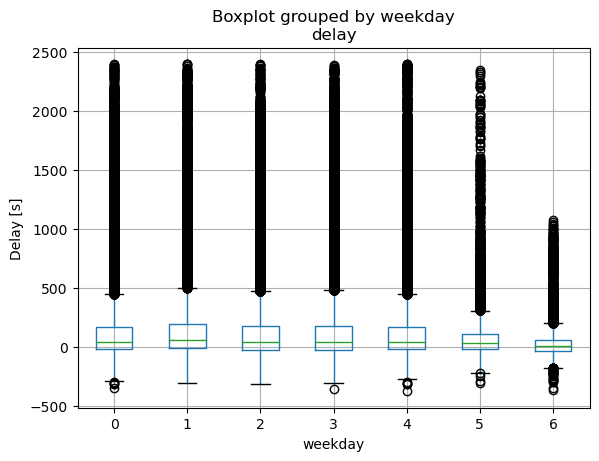

In [46]:
plt.figure(figsize=(10, 5))
df_for_modelling.boxplot(column='delay', by='weekday')
plt.ylabel("Delay [s]")
plt.show()

We can see clearly that the average delay is higher on weekdays. Sunday delay is particularly low - due to decreased traffic.

Text(0, 0.5, 'Delay [s]')

<Figure size 1000x500 with 0 Axes>

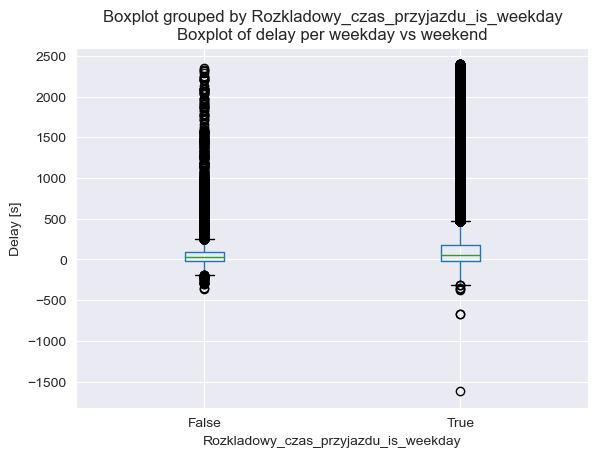

In [10]:
plt.figure(figsize=(10, 5))
df_for_modelling.boxplot(column='delay', by='Rozkladowy_czas_przyjazdu_is_weekday')
plt.title("Boxplot of delay per weekday vs weekend")
plt.ylabel("Delay [s]")


Text(0.5, 1.0, 'Boxplot of delay per time of day')

<Figure size 1000x500 with 0 Axes>

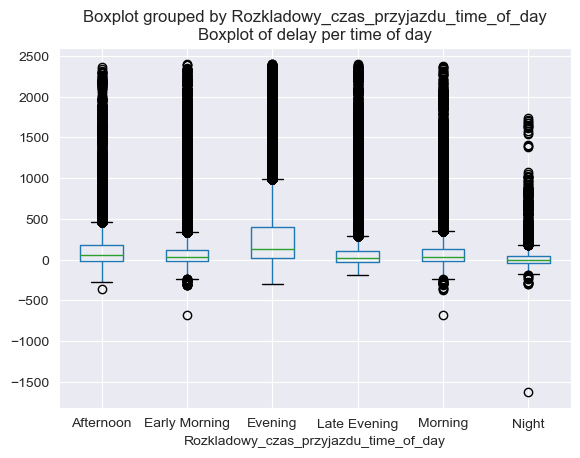

In [11]:
plt.figure(figsize=(10, 5))
df_for_modelling.boxplot(column='delay', by='Rozkladowy_czas_przyjazdu_time_of_day')
plt.title("Boxplot of delay per time of day")

Text(0.5, 1.0, 'Boxplot of delay per holiday')

<Figure size 1000x500 with 0 Axes>

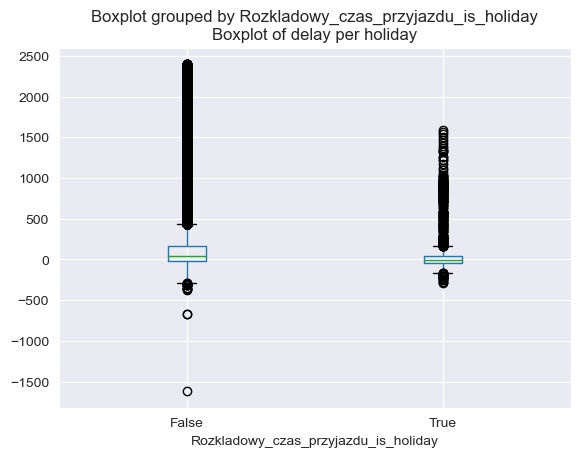

In [12]:
plt.figure(figsize=(10, 5))
df_for_modelling.boxplot(column='delay', by='Rozkladowy_czas_przyjazdu_is_holiday')
plt.title("Boxplot of delay per holiday")

We can see that the average delay is higher on weekdays, in the evening and on holidays. Let's explore the relationship between delay and stop.

<Axes: xlabel='stop_lon,stop_lat,stop_desc'>

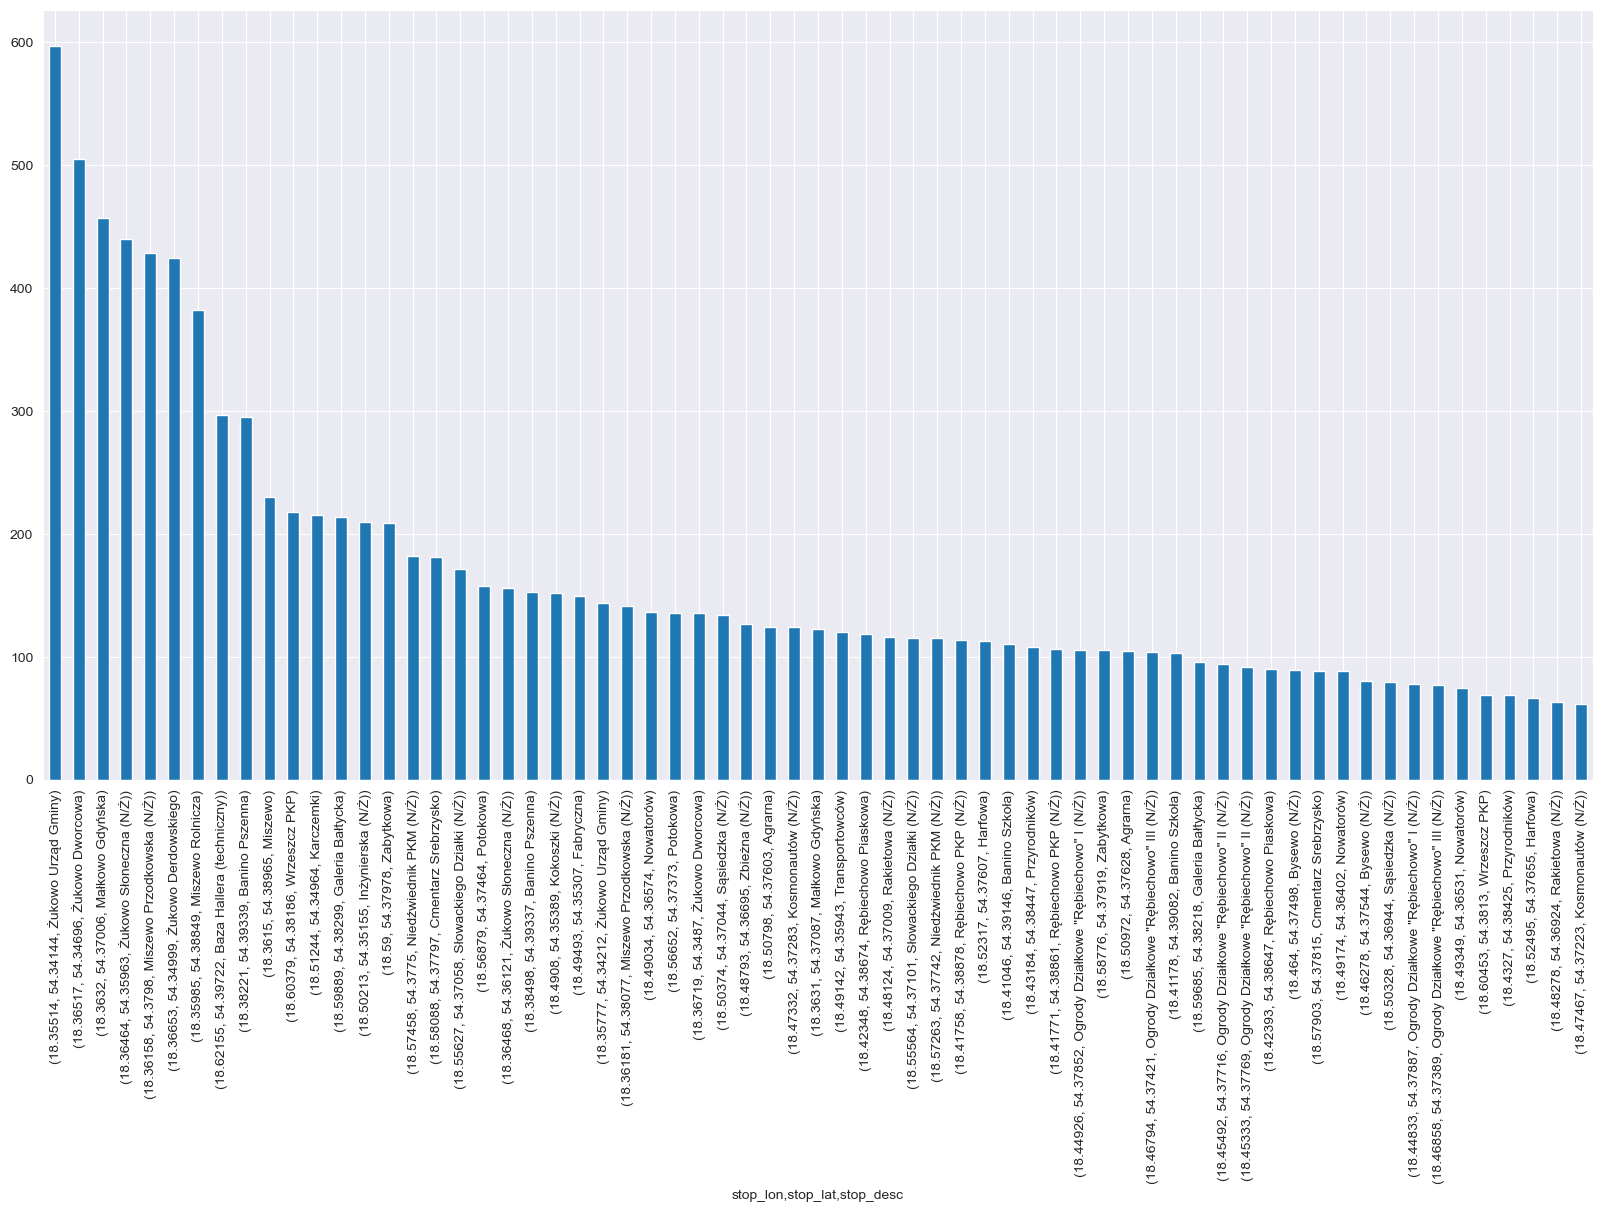

In [13]:
df_for_modelling.groupby(["stop_lon", "stop_lat", "stop_desc"])["delay"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))

We can now view the evolution of the delay over time. 

In [102]:
df_for_modelling.sort_values(['Zadanie', 'Rozkladowy czas przyjazdu'], inplace=True)

trip_id = 1
trip_ids = [trip_id]

for i in range(1, len(df_for_modelling)):
    if df_for_modelling.loc[i, "Lp przystanku"] < df_for_modelling.loc[i - 1, "Lp przystanku"]:
        trip_id += 1
    trip_ids.append(trip_id)

df_for_modelling["Trip ID"] = trip_ids

We can see the delay of the first 50 trips at 5 am. 

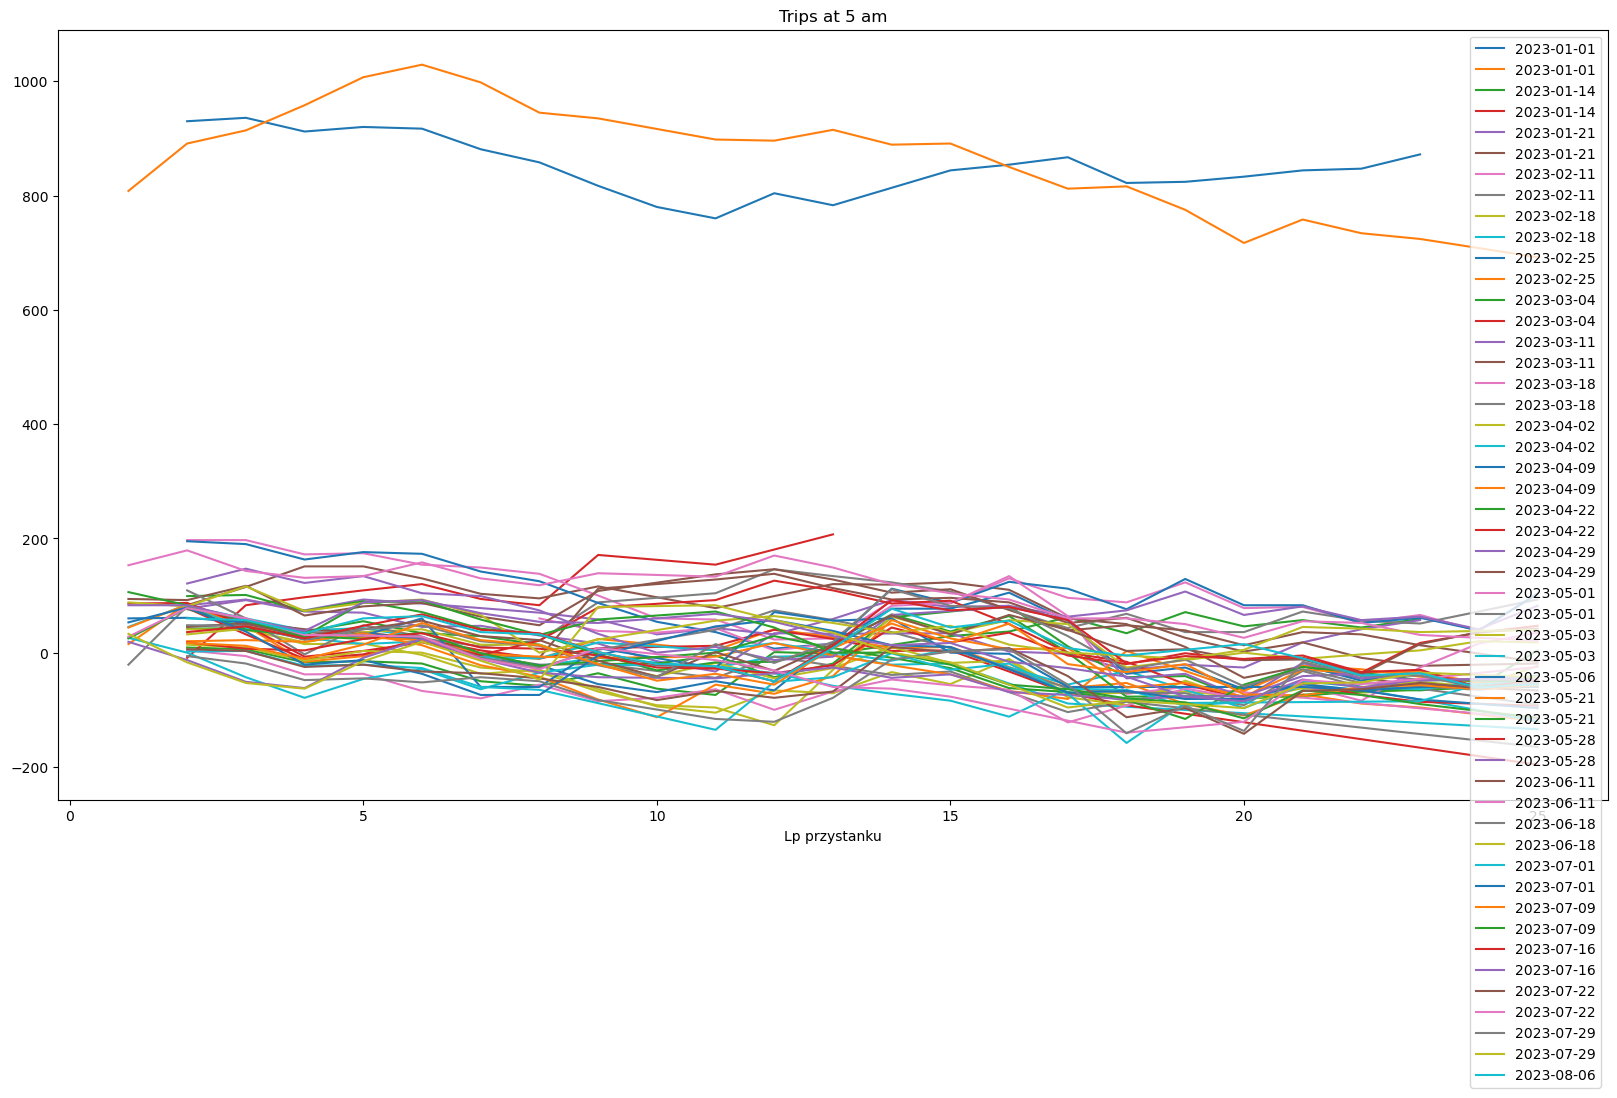

In [118]:
def plot_delay_evolution(hour=5, trips_count=50):
    plt.figure(figsize=(20,10))
    for trip_id in df_for_modelling[(df_for_modelling['Rozkladowy czas przyjazdu'].dt.hour >= hour) & (df_for_modelling['Rozkladowy czas przyjazdu'].dt.hour < hour+1)]["Trip ID"].unique()[:trips_count]:
        trip_day = df_for_modelling[df_for_modelling["Trip ID"] == trip_id]["Rozkladowy czas przyjazdu"].dt.date.iloc[0]
        df_for_modelling[df_for_modelling["Trip ID"] == trip_id].plot(x='Lp przystanku', y='delay', title=f"Trips at 5 am", ax=plt.gca(),  label=str(trip_day))
    plt.show()
plot_delay_evolution()

Notice that most of the trips concentrate at around 0-200s of delay but there are two trips that have around 8 and 16 minutes of delay. Those are not outliers , they are both trips in the same day. Probably those two trips were operated by the same vehicle and one delayed trip led to another delayed trip. This graph allows us to see fluctuations of delay in the route.

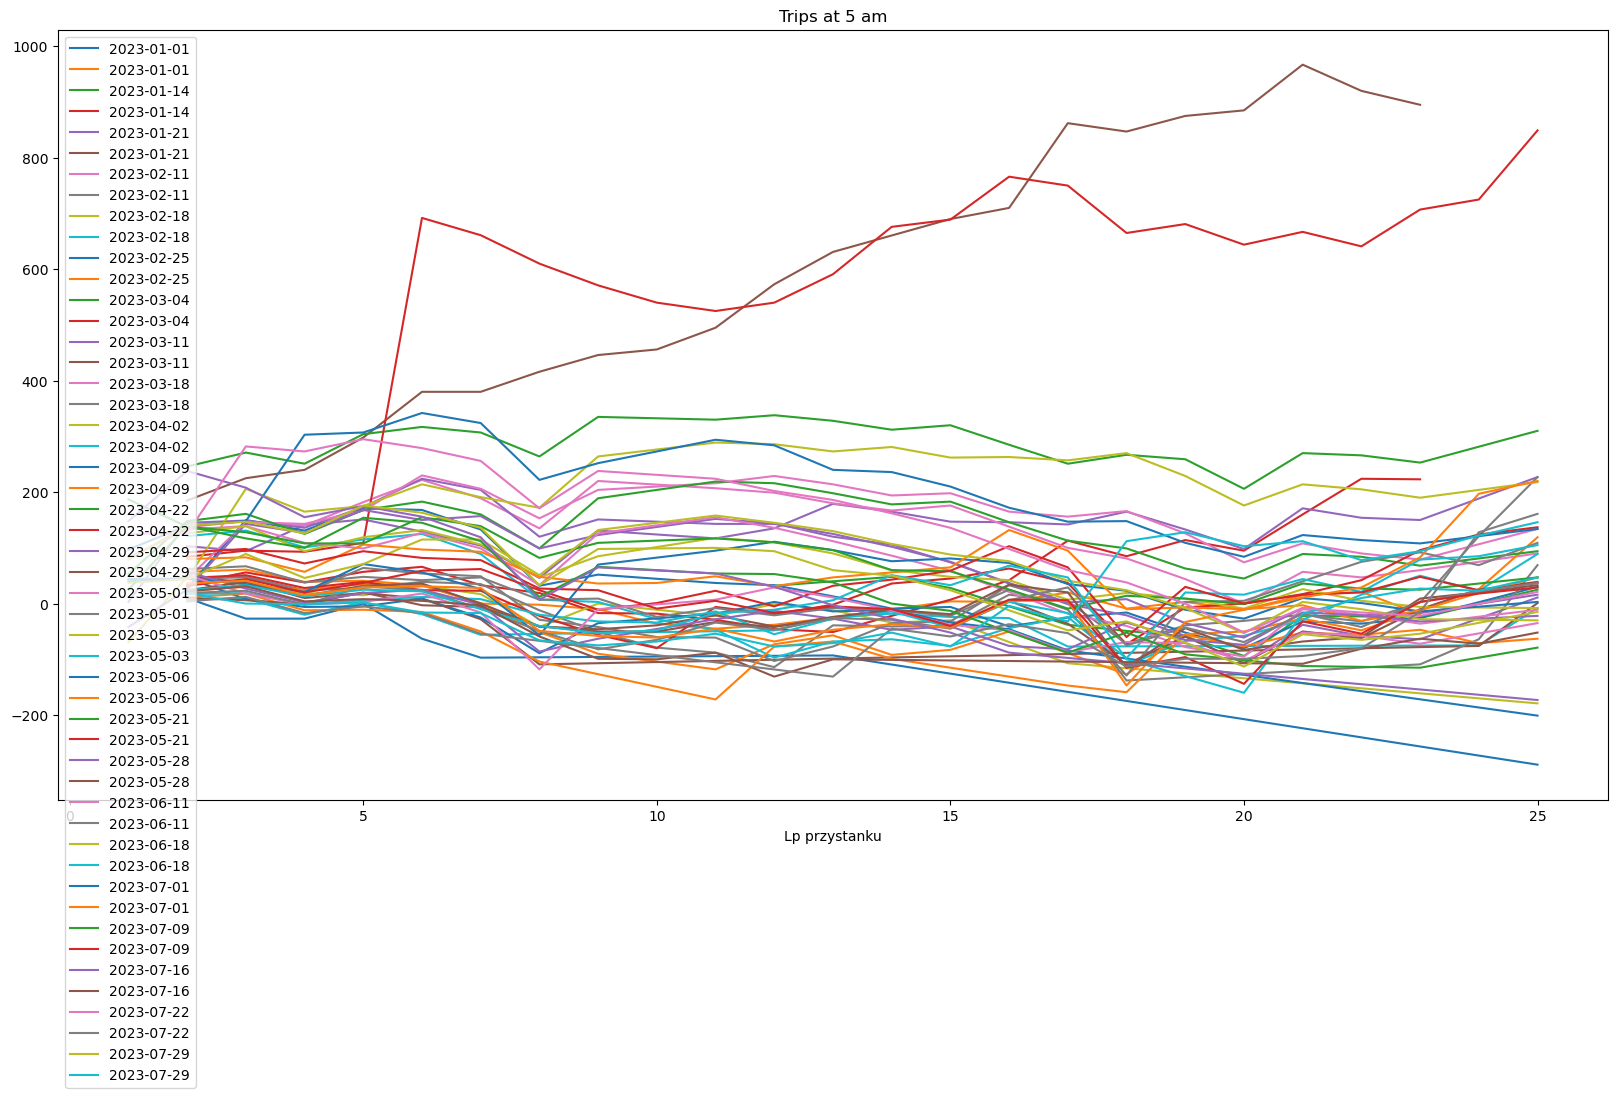

In [119]:
plot_delay_evolution(17)

We can see that the pattern of delay is different in the evening. The delay is higher and more volatile. This might be due to increased traffic in the evening. It also increases steadily with stops, whereas delay in the morning stays mostly constant.

## Modelling

In this part of the analysis we'll create a simple model to predict the delay of the bus. We'll train several different regression models, some baseline models. We'll evaluate the models and choose the best one to tune parameters on and improve.

In [10]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def prepare_train_test_datasets(dataframe, selected_features, prediction_target, dummies_cols, cyclical_encoding_cols=None):
    X = dataframe[selected_features]
    y = dataframe[prediction_target]
    
    # encoding categorical variables
    X = pd.get_dummies(X, columns=dummies_cols)
    if cyclical_encoding_cols:
        for c in cyclical_encoding_cols:
            unique_values = len(X[c].unique())
            X[f'{c}_sin'] = np.sin(2 * np.pi * X[c] / unique_values)
            X[f'{c}_cos'] = np.cos(2 * np.pi * X[c] / unique_values)


    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    return x_train, x_test, y_train, y_test


def train_model(dataframe, selected_features, prediction_target, models_to_test, dummies_cols, cyclical_encoding_cols=None):
    x_train, x_test, y_train, y_test = prepare_train_test_datasets(dataframe, selected_features, prediction_target, dummies_cols, cyclical_encoding_cols)
    
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5) 
    for model in models_to_test:
        cv_scores = cross_val_score(model, x_train, y_train, cv=tscv, scoring=rmse_scorer)
        print(f"Model: {model.__class__.__name__}")
        print(f"Cross-Validated RMSE Scores: {cv_scores}")
        print(f"Mean RMSE: {np.mean(cv_scores)}, Standard Deviation: {np.std(cv_scores)}")
        
def fit_best_model(best_model, X,y):
    best_model.fit(X, y)
    return best_model

def train_baseline_models(dataframe, selected_features, prediction_target, dummies_cols):
    x_train, x_test, y_train, y_test = prepare_train_test_datasets(dataframe, selected_features, prediction_target, dummies_cols)
    mean_baseline = DummyRegressor(strategy="mean")
    median_baseline = DummyRegressor(strategy="median")
    quantile = DummyRegressor(strategy="quantile", quantile=0.75)
    
    tscv = TimeSeriesSplit(n_splits=5) 
    
    
    for baseline in [mean_baseline, median_baseline, quantile]:
        cv_scores = cross_val_score(baseline, x_train, y_train, cv=tscv, scoring="neg_root_mean_squared_error")
        print(f"Baseline Model ({baseline.strategy} Prediction) Cross-Validated RMSE Scores: {cv_scores}")
        print(f"Mean RMSE: {np.mean(cv_scores)}, Standard Deviation: {np.std(cv_scores)}")
    

## Simple model with base features

We'll start with features provided in the dataset:
- stop lat
- stop lon
- Lp przystanku

plus features calculated from the time of arrival:
- categorized time of day
- weekday/weekend
- holiday/not holiday

As we saw in analysis those features have a relationship with delay so they might be useful in predicting it. This set of features is limited but it's a good start.

In [123]:
selected_features = ["Lp przystanku", "Rozkladowy_czas_przyjazdu_is_weekday", "Rozkladowy_czas_przyjazdu_time_of_day", "Rozkladowy_czas_przyjazdu_is_holiday", "stop_lat", "stop_lon"]
prediction_target = 'delay'
dummies_cols = ['Rozkladowy_czas_przyjazdu_is_weekday', 'Rozkladowy_czas_przyjazdu_time_of_day', 'Rozkladowy_czas_przyjazdu_is_holiday']

train_baseline_models(df_for_modelling, selected_features, prediction_target, dummies_cols)

train_model(df_for_modelling, selected_features, prediction_target, [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor()], dummies_cols)


Baseline Model (mean Prediction) Cross-Validated RMSE Scores: [-315.90589508 -333.25236361 -308.45245112 -307.05881761 -312.71559486]
Mean RMSE: -315.4770244556704, Standard Deviation: 9.423194175996343
Baseline Model (median Prediction) Cross-Validated RMSE Scores: [-326.46746532 -350.46722984 -328.27309949 -328.19145403 -333.61871745]
Mean RMSE: -333.40359322854545, Standard Deviation: 8.863545614539353
Baseline Model (quantile Prediction) Cross-Validated RMSE Scores: [-307.30275782 -330.38939584 -306.82257402 -305.53096627 -311.58396035]
Mean RMSE: -312.32593086081465, Standard Deviation: 9.257753886177136
Model: LinearRegression
Cross-Validated RMSE Scores: [-322.24658553 -306.50341849 -288.72747757 -289.43494997 -294.64814405]
Mean RMSE: -300.3121151209979, Standard Deviation: 12.681091015389347
Model: DecisionTreeRegressor
Cross-Validated RMSE Scores: [-328.72561059 -301.24528489 -278.41279615 -293.84990277 -288.92910742]
Mean RMSE: -298.2325403640597, Standard Deviation: 16.9557

In [124]:
def evaluate_model(best_model, X, y, x_test, y_test):
    best_model = fit_best_model(best_model, X, y)
    y_pred = best_model.predict(X)
    y_test_pred = best_model.predict(x_test)
    print(f"RMSE: {root_mean_squared_error(y_test, y_test_pred)}")
    feature_importance = best_model.feature_importances_
    
    sorted_idx = feature_importance.argsort()
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(X.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
    # get top 5 columns from feature importance
    top_5_features = X.columns[np.argsort(feature_importance)[::-1][:5]]
    

    fig, ax = plt.subplots(figsize=(20, 8)) 
    features = [0, 1, (0, 1)]
    PartialDependenceDisplay.from_estimator(best_model, X, features,ax=ax)
    
    fig, ax = plt.subplots(figsize=(20, 20)) 
    PartialDependenceDisplay.from_estimator(
        best_model, X, top_5_features, kind="individual", ax=ax
    )
    
    plt.show()
    
    
  

RMSE: 254.17254841590236


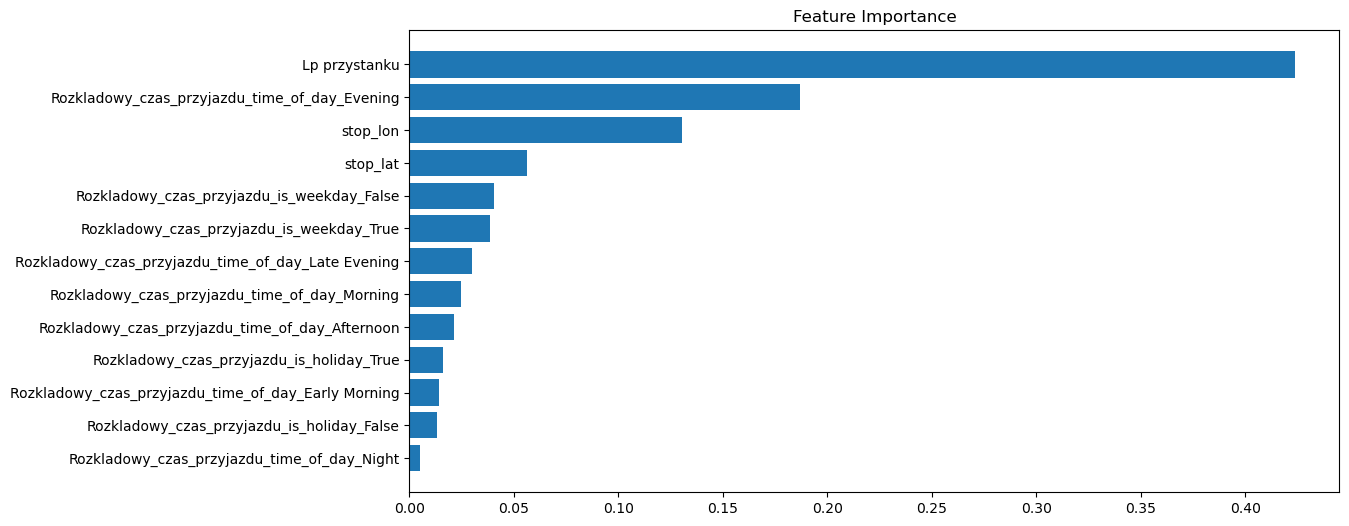

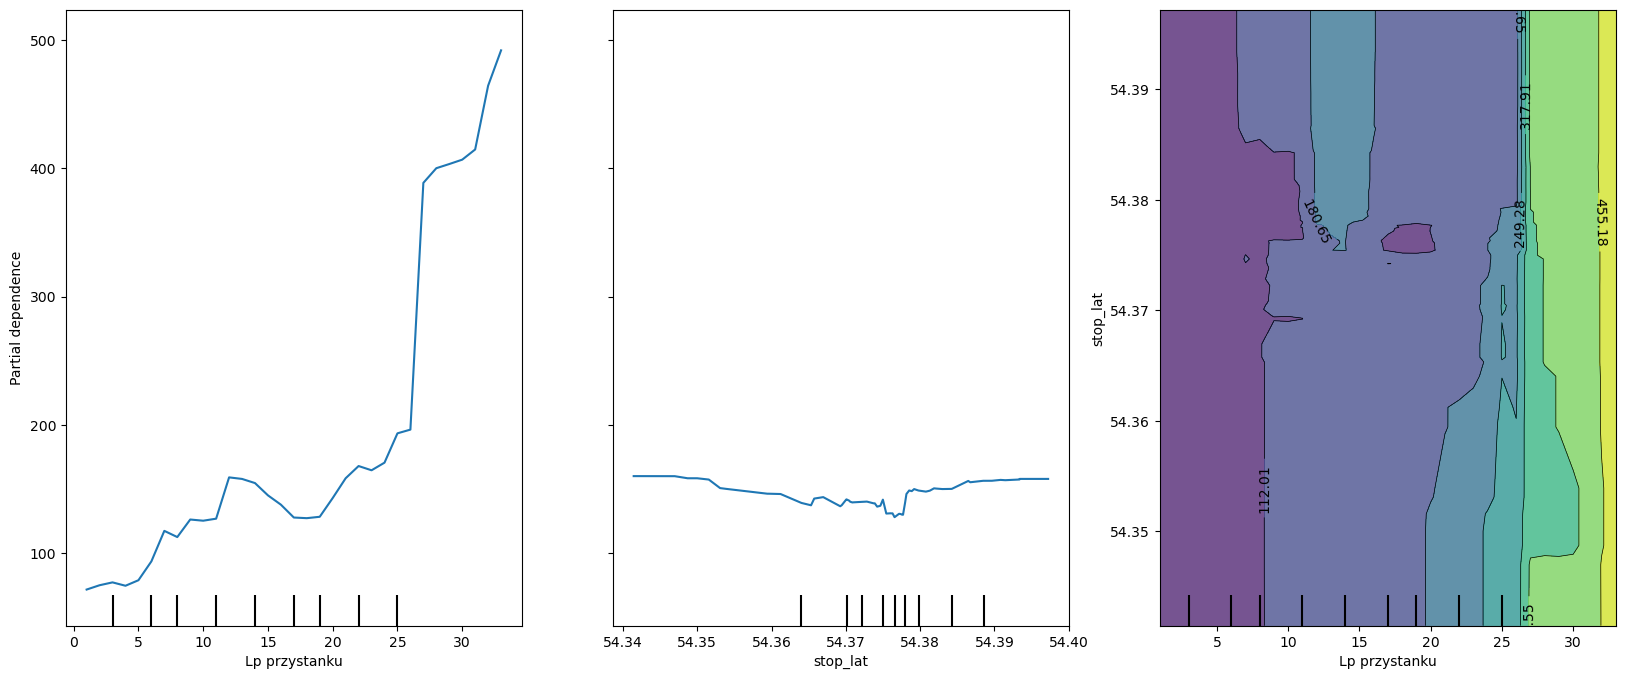

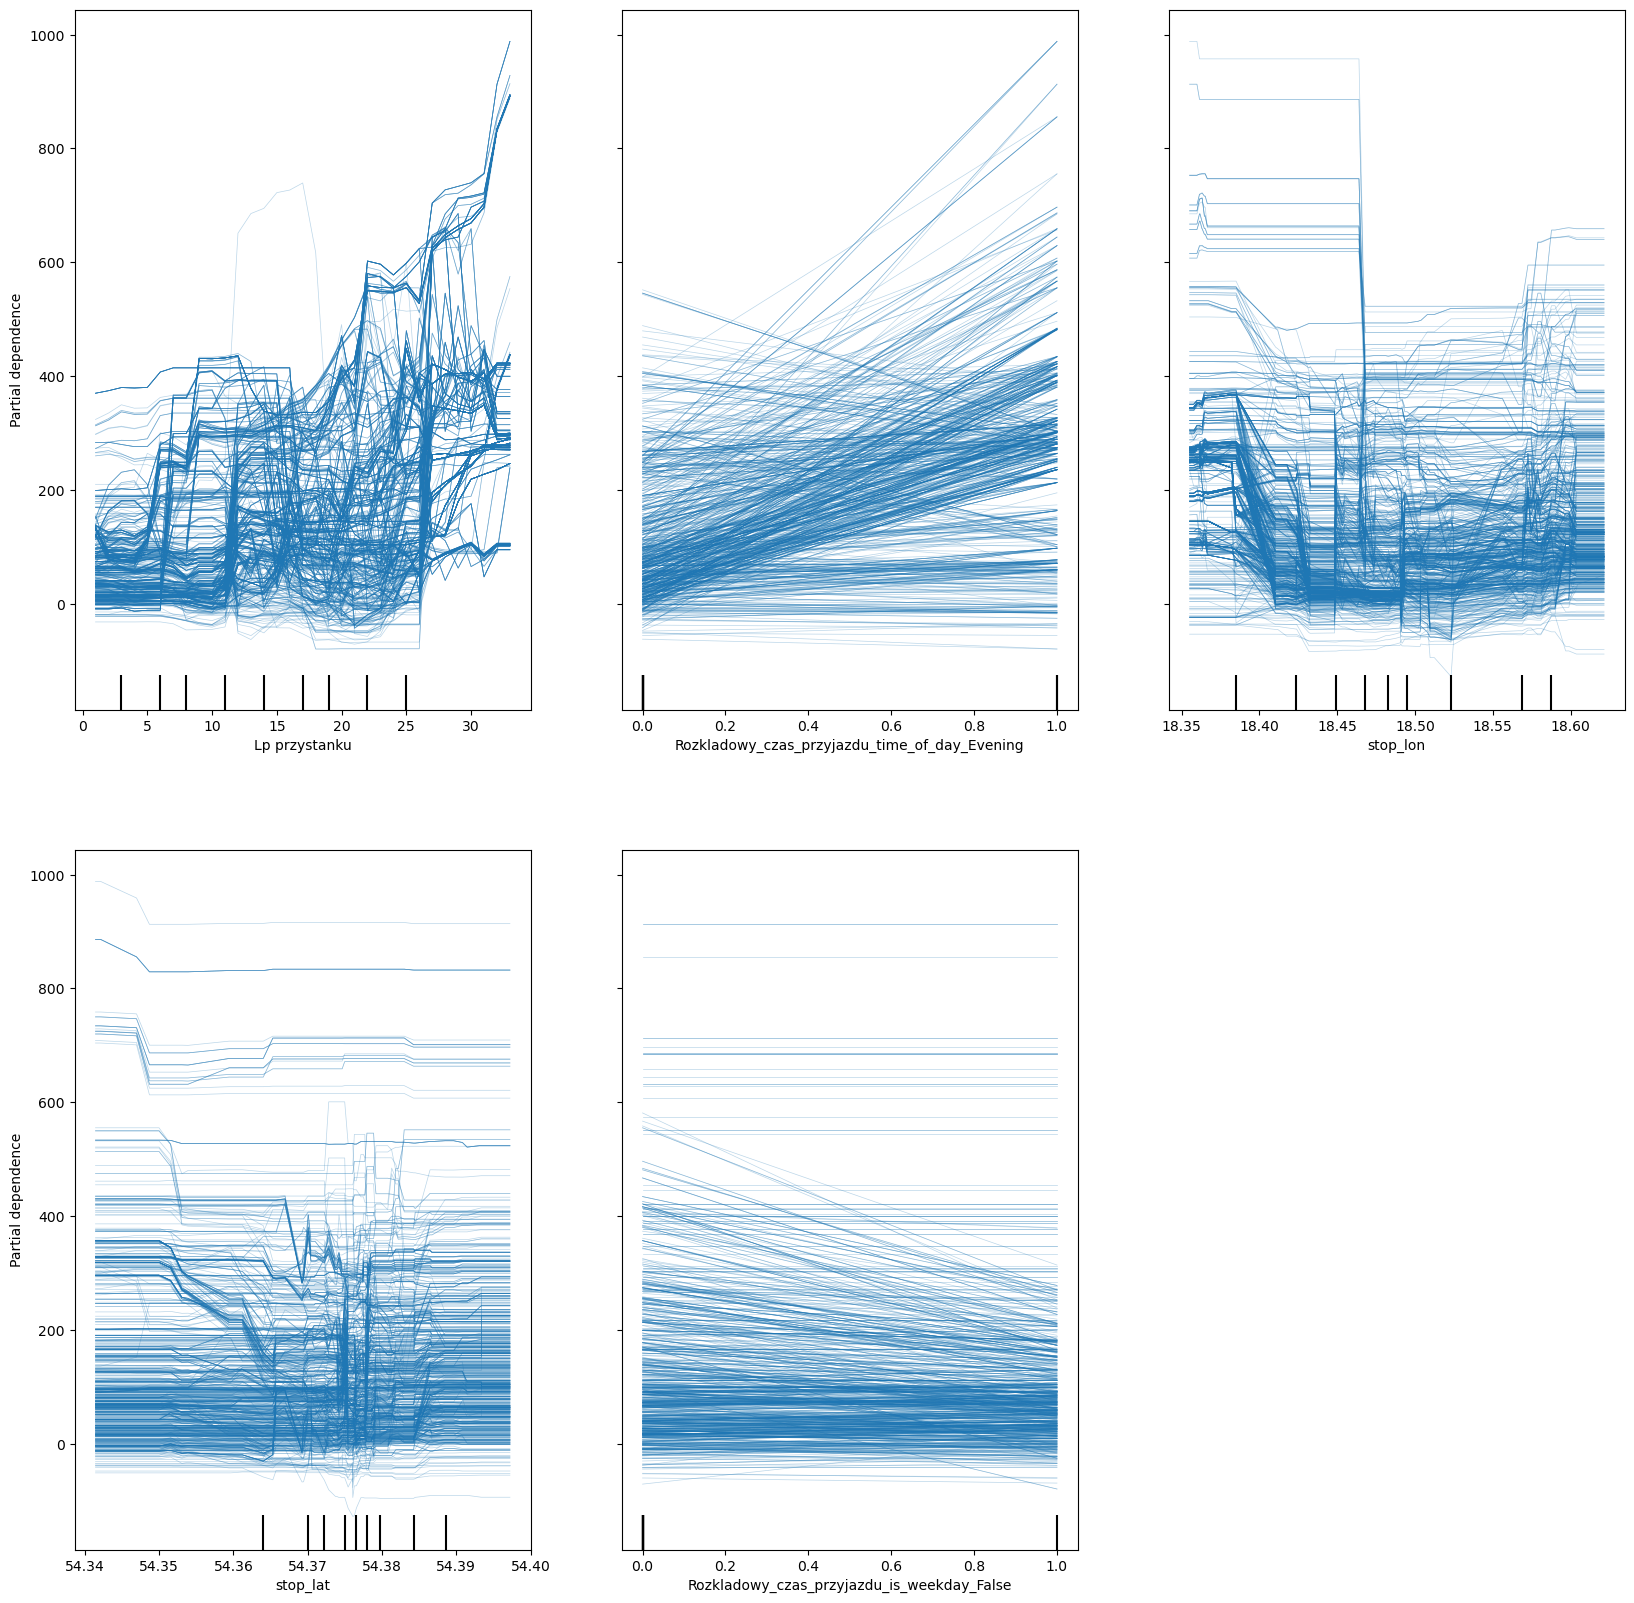

In [125]:
x_train, x_test, y_train, y_test = prepare_train_test_datasets(df_for_modelling, selected_features, prediction_target, dummies_cols)
evaluate_model(RandomForestRegressor(), x_train, y_train, x_test, y_test)

We tested several models and the best one is Random Forest Regressor. The model is better than baseline models. We can see that the most important feature is the number of stop in the route. The higher the number of stop, the higher the delay. The second most important feature is the latitude of the stop. The higher the latitude, the higher the delay. The third most important feature is the longitude of the stop. The higher the longitude, the higher the delay. The time of day is also important. The highest delay is in the evening. The model is not perfect, but we can improve it by adding new features.

## Add new features

We can still create new features from our base set. We can calculate the distance to the next stop, and the season of the year. 


In [133]:
from geopy.distance import geodesic
def calculate_distance_to_next_stop(_df):
    distances = []  
    
    for (index, row), (_, next_row) in zip(_df.iterrows(), _df.shift(-1).iterrows()):
        try:
            if next_row['Lp przystanku'] > row['Lp przystanku']:
                distance = geodesic(
                    (row["stop_lat"], row["stop_lon"]),
                    (next_row["stop_lat"], next_row["stop_lon"])
                ).meters
            else:
               
                distance = 0
            
            distances.append(distance) 
        except:
            distances.append(0)
    
    _df["distance_to_next_stop"] = distances
    
    return _df

def categorize_season(month):
    if 3 <= month <= 5:
        return 1
    elif 6 <= month <= 8:
        return 2
    elif 9 <= month <= 11:
        return 3
    else:
        return 4
    
df_for_modelling = transform_date_columns(df_for_modelling, cols  = ['Rozkladowy czas przyjazdu']
)   
df_for_modelling = calculate_distance_to_next_stop(df_for_modelling)
df_for_modelling["season"] = df_for_modelling["Rozkladowy czas przyjazdu"].dt.month.apply(categorize_season)
df_for_modelling

Zadanie Linia  Lp przystanku Rozkladowy czas przyjazdu  \
0       126-01   126              2       2023-01-01 05:25:00   
1       126-01   126              3       2023-01-01 05:26:00   
2       126-01   126              4       2023-01-01 05:27:00   
3       126-01   126              5       2023-01-01 05:28:00   
4       126-01   126              6       2023-01-01 05:30:00   
...        ...   ...            ...                       ...   
365175  126-16   126             20       2024-06-14 08:32:00   
365176  126-16   126             21       2024-06-14 08:34:00   
365177  126-16   126             22       2024-06-14 08:36:00   
365178  126-16   126             23       2024-06-14 08:40:00   
365179  126-16   126             24       2024-06-14 08:41:00   

        Rodzaj detekcji  delay                              stop_desc  \
0                     2  930.0                          Banino Szkoła   
1                     2  936.0                   Rębiechowo PKP (N/Ż)   
2                     2  912.0                    Rębiechowo Piaskowa   
3                     2  920.0                           Przyrodników   
4                     2  917.0  Ogrody Działkowe "Rębiechowo" I (N/Ż)   
...                 ...    ...                                    ...   
365175                2  103.0                 Niedźwiednik PKM (N/Ż)   
365176                2   72.0                    Cmentarz Srebrzysko   
365177                2  108.0                              Zabytkowa   
365178                2  198.0                       Galeria Bałtycka   
365179                2  235.0                           Wrzeszcz PKP   

        stop_lat  stop_lon  Rozkladowy_czas_przyjazdu_is_weekday  ...  \
0       54.39082  18.41178                                 False  ...   
1       54.38861  18.41771                                 False  ...   
2       54.38647  18.42393                                 False  ...   
3       54.38447  18.43184                                 False  ...   
4       54.37852  18.44926                                 False  ...   
...          ...       ...                                   ...  ...   
365175  54.37750  18.57458                                  True  ...   
365176  54.37797  18.58088                                  True  ...   
365177  54.37978  18.59000                                  True  ...   
365178  54.38299  18.59889                                  True  ...   
365179  54.38186  18.60379                                  True  ...   

                    sunrise               sunset  moonphase  \
0       2023-01-01T08:06:31  2023-01-01T15:31:23       0.31   
1       2023-01-01T08:06:31  2023-01-01T15:31:23       0.31   
2       2023-01-01T08:06:31  2023-01-01T15:31:23       0.31   
3       2023-01-01T08:06:31  2023-01-01T15:31:23       0.31   
4       2023-01-01T08:06:31  2023-01-01T15:31:23       0.31   
...                     ...                  ...        ...   
365175  2024-06-14T04:10:30  2024-06-14T21:21:28       0.25   
365176  2024-06-14T04:10:30  2024-06-14T21:21:28       0.25   
365177  2024-06-14T04:10:30  2024-06-14T21:21:28       0.25   
365178  2024-06-14T04:10:30  2024-06-14T21:21:28       0.25   
365179  2024-06-14T04:10:30  2024-06-14T21:21:28       0.25   

                    conditions  \
0       Rain, Partially cloudy   
1       Rain, Partially cloudy   
2       Rain, Partially cloudy   
3       Rain, Partially cloudy   
4       Rain, Partially cloudy   
...                        ...   
365175  Rain, Partially cloudy   
365176  Rain, Partially cloudy   
365177  Rain, Partially cloudy   
365178  Rain, Partially cloudy   
365179  Rain, Partially cloudy   

                                              description  icon  \
0       Partly cloudy throughout the day with rain cle...  rain   
1       Partly cloudy throughout the day with rain cle...  rain   
2       Partly cloudy throughout the day with rain cle...  rain   
3       Partly cloudy throughout the d

Let's see if there is a pattern of delay in the distance to the next stop and season.

<Figure size 1000x500 with 0 Axes>

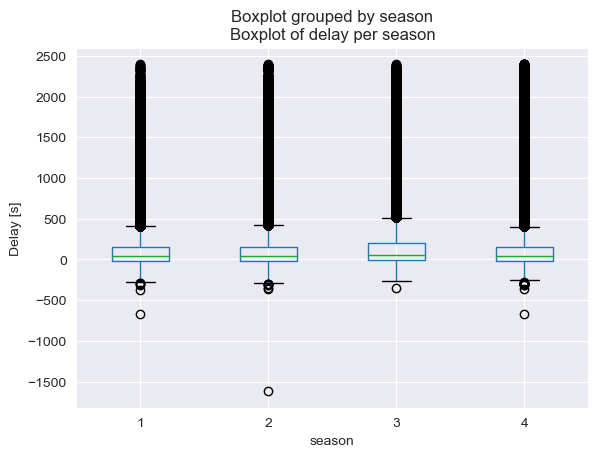

In [45]:
plt.figure(figsize=(10, 5))
df_for_modelling.boxplot(column='delay', by='season')
plt.title("Boxplot of delay per season")
plt.ylabel("Delay [s]")
plt.show()

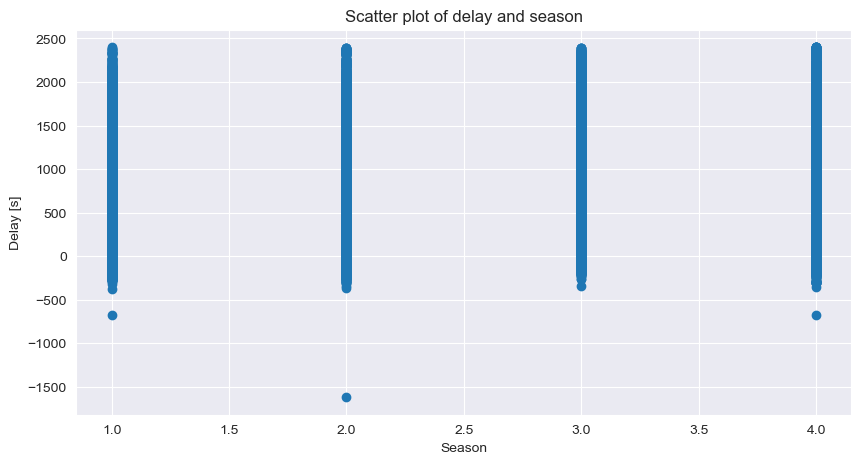

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(df_for_modelling["season"], df_for_modelling["delay"])
plt.title("Scatter plot of delay and season")
plt.xlabel("Season")
plt.ylabel("Delay [s]")
plt.show()

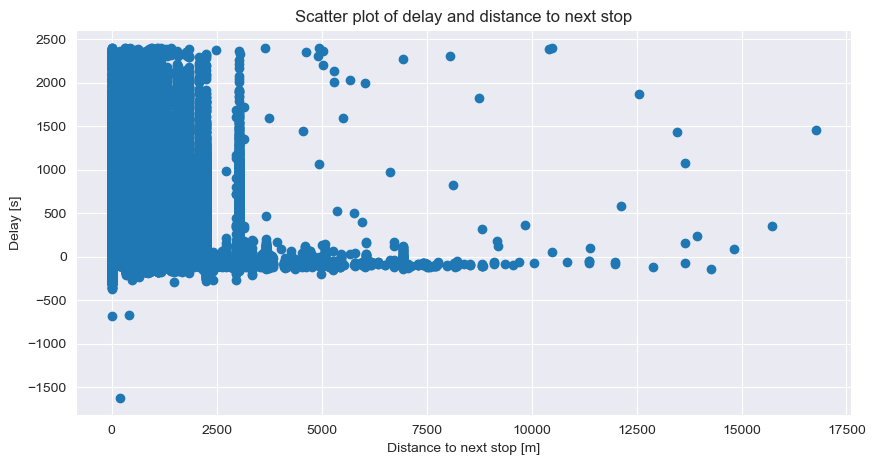

In [47]:
plt.figure(figsize=(10, 5))
plt.scatter(df_for_modelling["distance_to_next_stop"], df_for_modelling["delay"])
plt.title("Scatter plot of delay and distance to next stop")
plt.xlabel("Distance to next stop [m]")
plt.ylabel("Delay [s]")
plt.show()

We can see that the average delay is the highest in the summer and the lowest in the winter. The delay is higher when the distance to the next stop is higher. Let's add weather data to our dataset. We'll also add the average delay of the last 10 observations as it might be a good indicator of the delay.

In [127]:
def append_weather_info(df_for_modelling: pd.DataFrame, weather_df: pd.DataFrame) -> pd.DataFrame:
    df_for_modelling["datetime"] = df_for_modelling["Rozkladowy czas przyjazdu"].dt.date
    df_for_modelling["datetime"] = pd.to_datetime(df_for_modelling["datetime"])
    weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])
    merged_df = pd.merge(df_for_modelling, weather_df, on="datetime", how="left")
    return merged_df

weather_df = pd.read_csv("Gdansk 2023-01-01 to 2025-01-15.csv")
df_for_modelling = append_weather_info(df_for_modelling, weather_df)
df_for_modelling["average_delay_last_10_observations"] = df_for_modelling["delay"].rolling(window=10).mean()

In [129]:
df_for_modelling["average_delay_last_10_observations"].fillna(0, inplace=True)

In [46]:
weather_df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

From those columns we're interested in weather conditions that can affect the delay of the bus. We'll use the following features:

In [13]:
selected_weather_features = ["humidity", "tempmax", "tempmin", "precip", "snowdepth", "visibility", "windspeed", "cloudcover"]

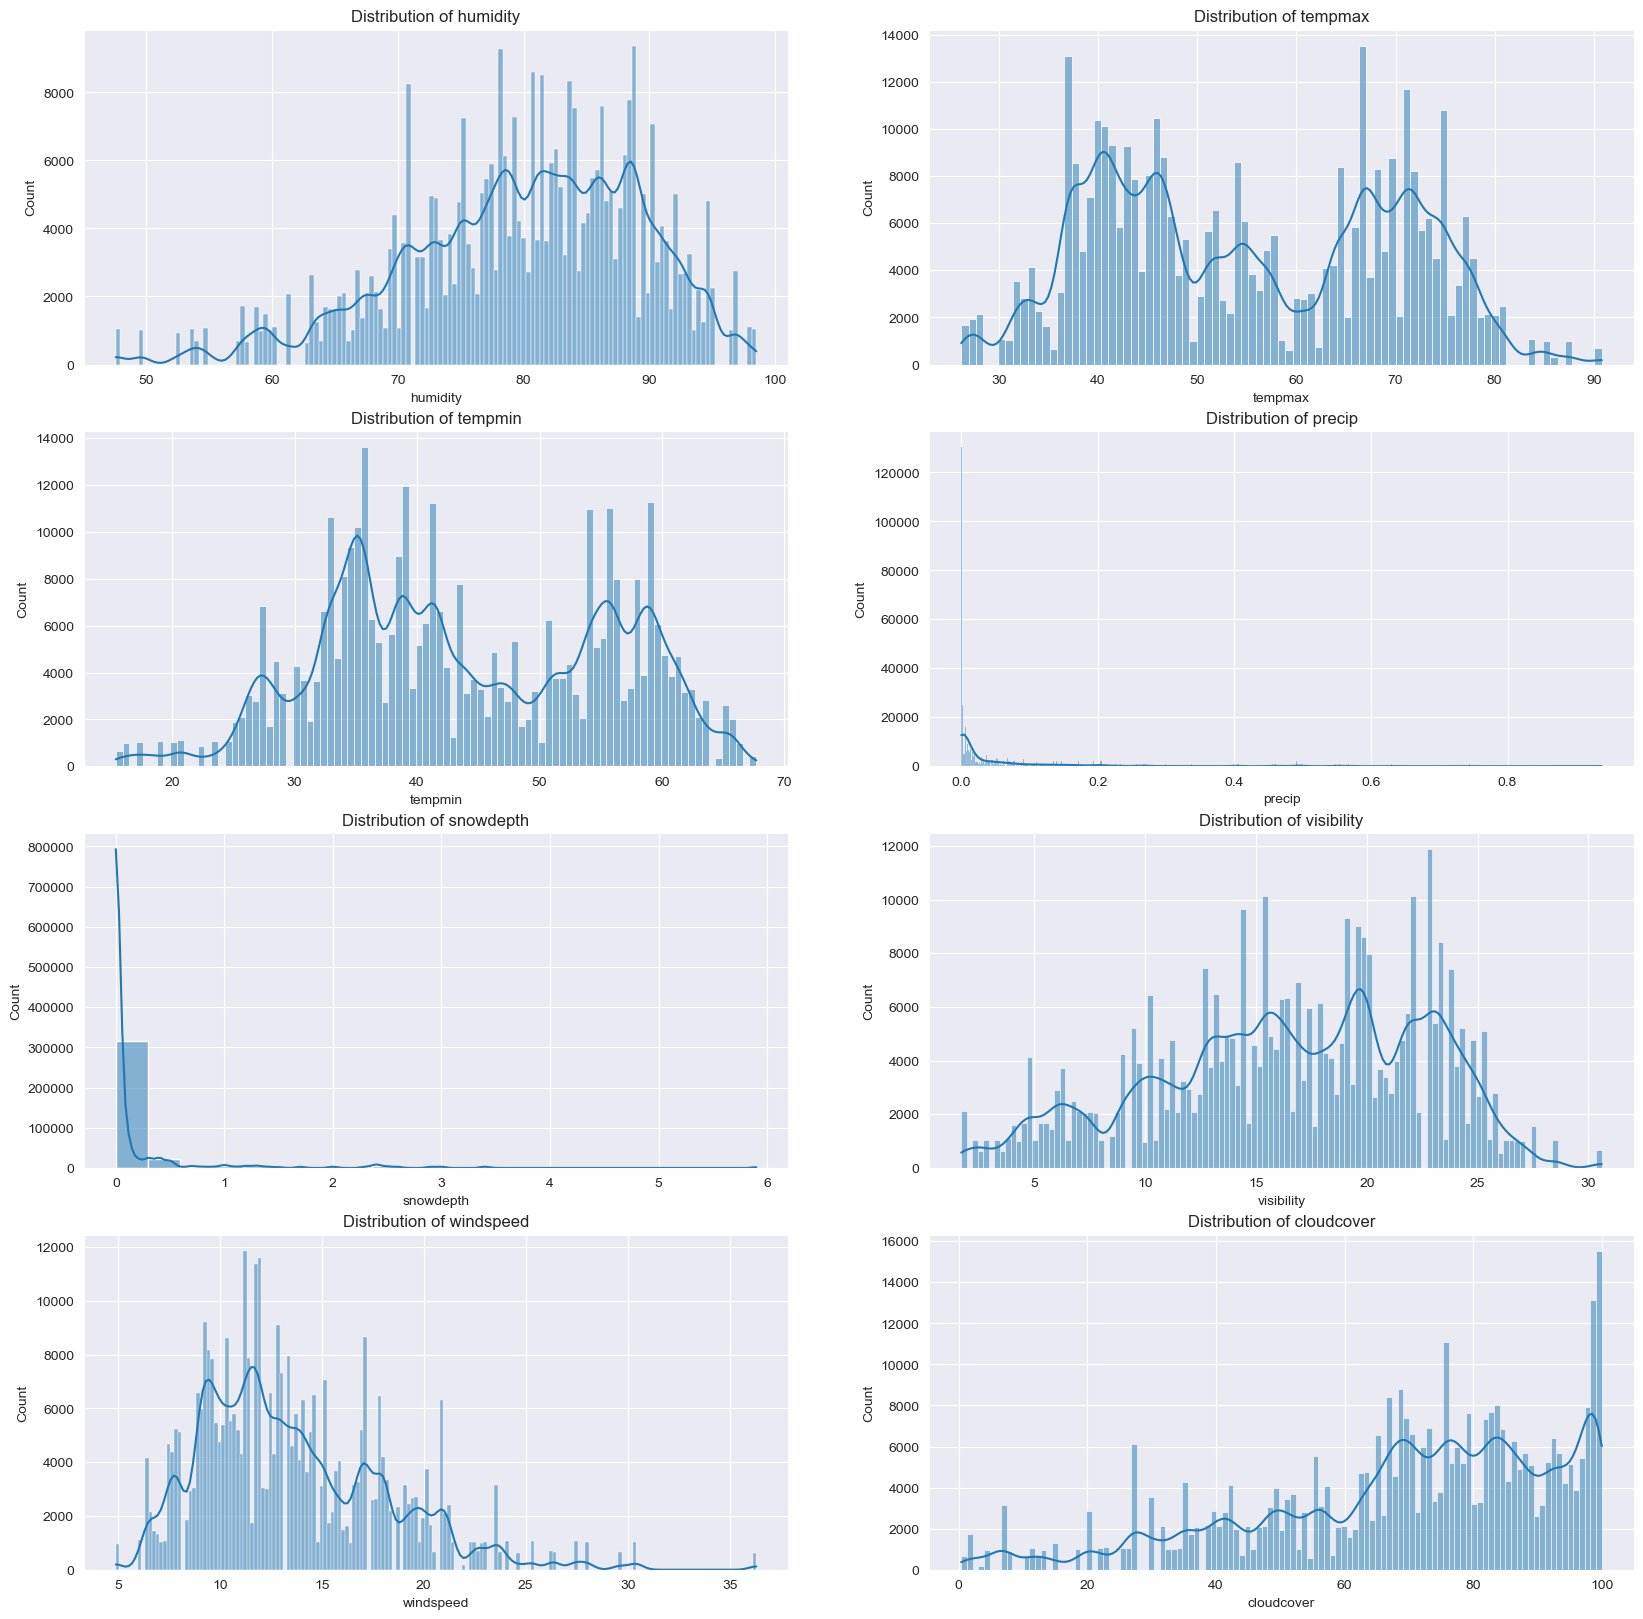

In [60]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for i, feature in enumerate(selected_weather_features):
    sns.histplot(df_for_modelling[feature], ax=axes[i // 2, i % 2], kde=True)
    axes[i // 2, i % 2].set_title(f"Distribution of {feature}")

precip and snowdepth are right-skewed. cloudcover is left-skewed. Both temp min and temp max have bi-modal distribution.

Let's also examine the correlation between different weather features and delay.

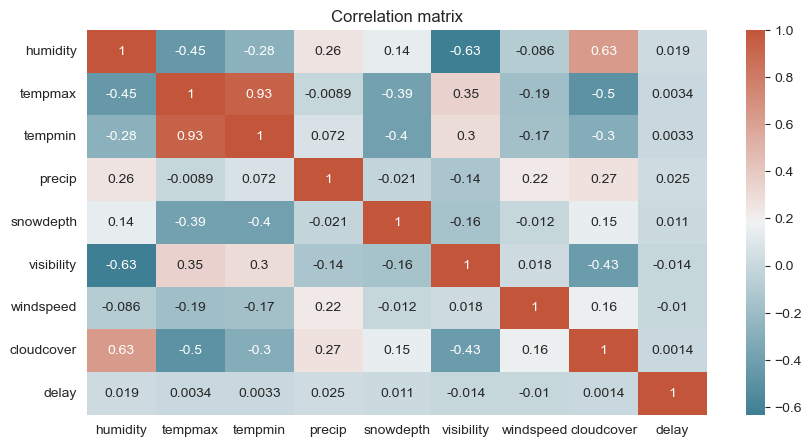

In [61]:
corr = df_for_modelling[selected_weather_features + ["delay"]].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Correlation matrix")
plt.show()

We can see that tempmin and tempmax are strongly positively correlated - it makes sense as they are related to each other. Tempmax and visibility are also positively correlated. Probably visibility is higher when the temperature is higher - when temperature is higher we can also expect less precipitation and snow. Humidity is negatively correlated with visibility - when humidity is higher visibility is lower. As for correlation between target(delay) and weather features - there is no strong correlation. We can see a weak negative correlation between delay and visibility. As visibility is lower, the delay is higher. Those features are gathered daily so might not reflect the exact weather conditions at the time of the bus arrival. We see that weather features are weakly correlated with delay, so they might not have as strong of a predictive power as we thought. Let's see how the model performs with new features.

In [131]:
df_for_modelling.columns

Index(['Zadanie', 'Linia', 'Lp przystanku', 'Rozkladowy czas przyjazdu',
       'Rodzaj detekcji', 'delay', 'stop_desc', 'stop_lat', 'stop_lon',
       'Rozkladowy_czas_przyjazdu_is_weekday',
       'Rozkladowy_czas_przyjazdu_time_of_day',
       'Rozkladowy_czas_przyjazdu_is_holiday',
       'Rozkladowy_czas_przyjazdu_hour', 'weekday', 'day_name', 'trip_id',
       'Trip ID', 'datetime', 'name', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions',
       'description', 'icon', 'stations',
       'average_delay_last_10_observations'],
      dtype='object')

In [134]:
selected_features = ["Lp przystanku", "Rozkladowy_czas_przyjazdu_is_weekday", "Rozkladowy_czas_przyjazdu_time_of_day", "Rozkladowy_czas_przyjazdu_is_holiday", "stop_lat", "stop_lon", "distance_to_next_stop", "average_delay_last_10_observations", "season"] + selected_weather_features
prediction_target = 'delay'
dummies_cols = ['Rozkladowy_czas_przyjazdu_is_weekday', 'Rozkladowy_czas_przyjazdu_time_of_day', 'Rozkladowy_czas_przyjazdu_is_holiday']
cycle_cols = ["season"]

train_baseline_models(df_for_modelling, selected_features, prediction_target, dummies_cols)

train_model(df_for_modelling, selected_features, prediction_target, [DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor()], dummies_cols, cycle_cols)

Baseline Model (mean Prediction) Cross-Validated RMSE Scores: [-315.90589508 -333.25236361 -308.45245112 -307.05881761 -312.71559486]
Mean RMSE: -315.4770244556704, Standard Deviation: 9.423194175996343
Baseline Model (median Prediction) Cross-Validated RMSE Scores: [-326.46746532 -350.46722984 -328.27309949 -328.19145403 -333.61871745]
Mean RMSE: -333.40359322854545, Standard Deviation: 8.863545614539353
Baseline Model (quantile Prediction) Cross-Validated RMSE Scores: [-307.30275782 -330.38939584 -306.82257402 -305.53096627 -311.58396035]
Mean RMSE: -312.32593086081465, Standard Deviation: 9.257753886177136
Model: DecisionTreeRegressor
Cross-Validated RMSE Scores: [-218.98325698 -182.85859366 -183.59469557 -171.02875116 -189.51958663]
Mean RMSE: -189.19697679897791, Standard Deviation: 16.055974854141468
Model: RandomForestRegressor
Cross-Validated RMSE Scores: [-141.99088837 -127.21720915 -129.32461415 -122.44592952 -134.11679041]
Mean RMSE: -131.01908631946836, Standard Deviation: 

Adding new features improved our model significantly. Let's now evaluate models and see what has changed in feature importance.

RMSE: 125.22133961956847


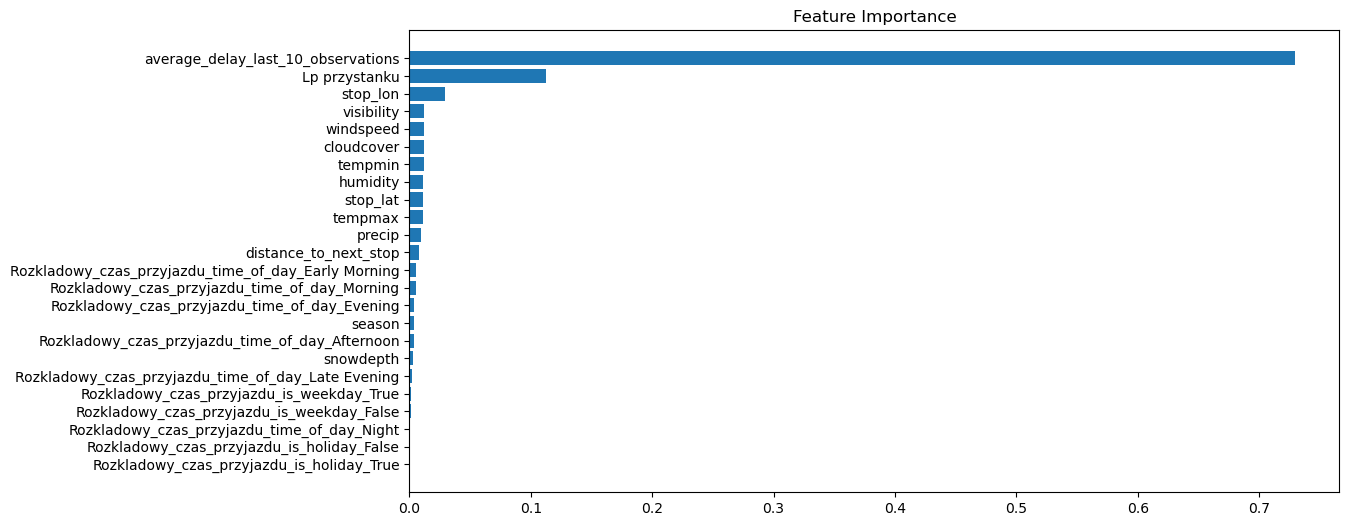

KeyboardInterrupt: 

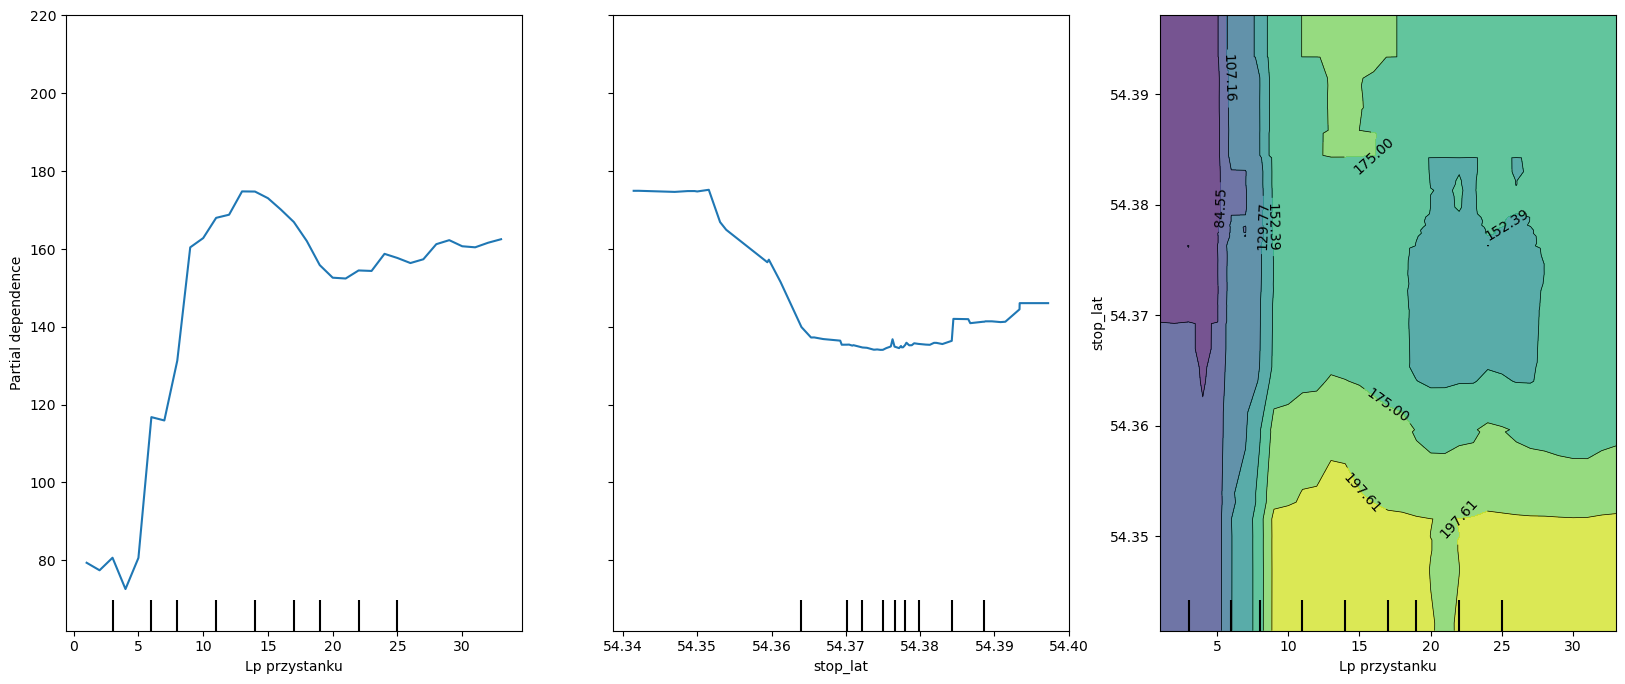

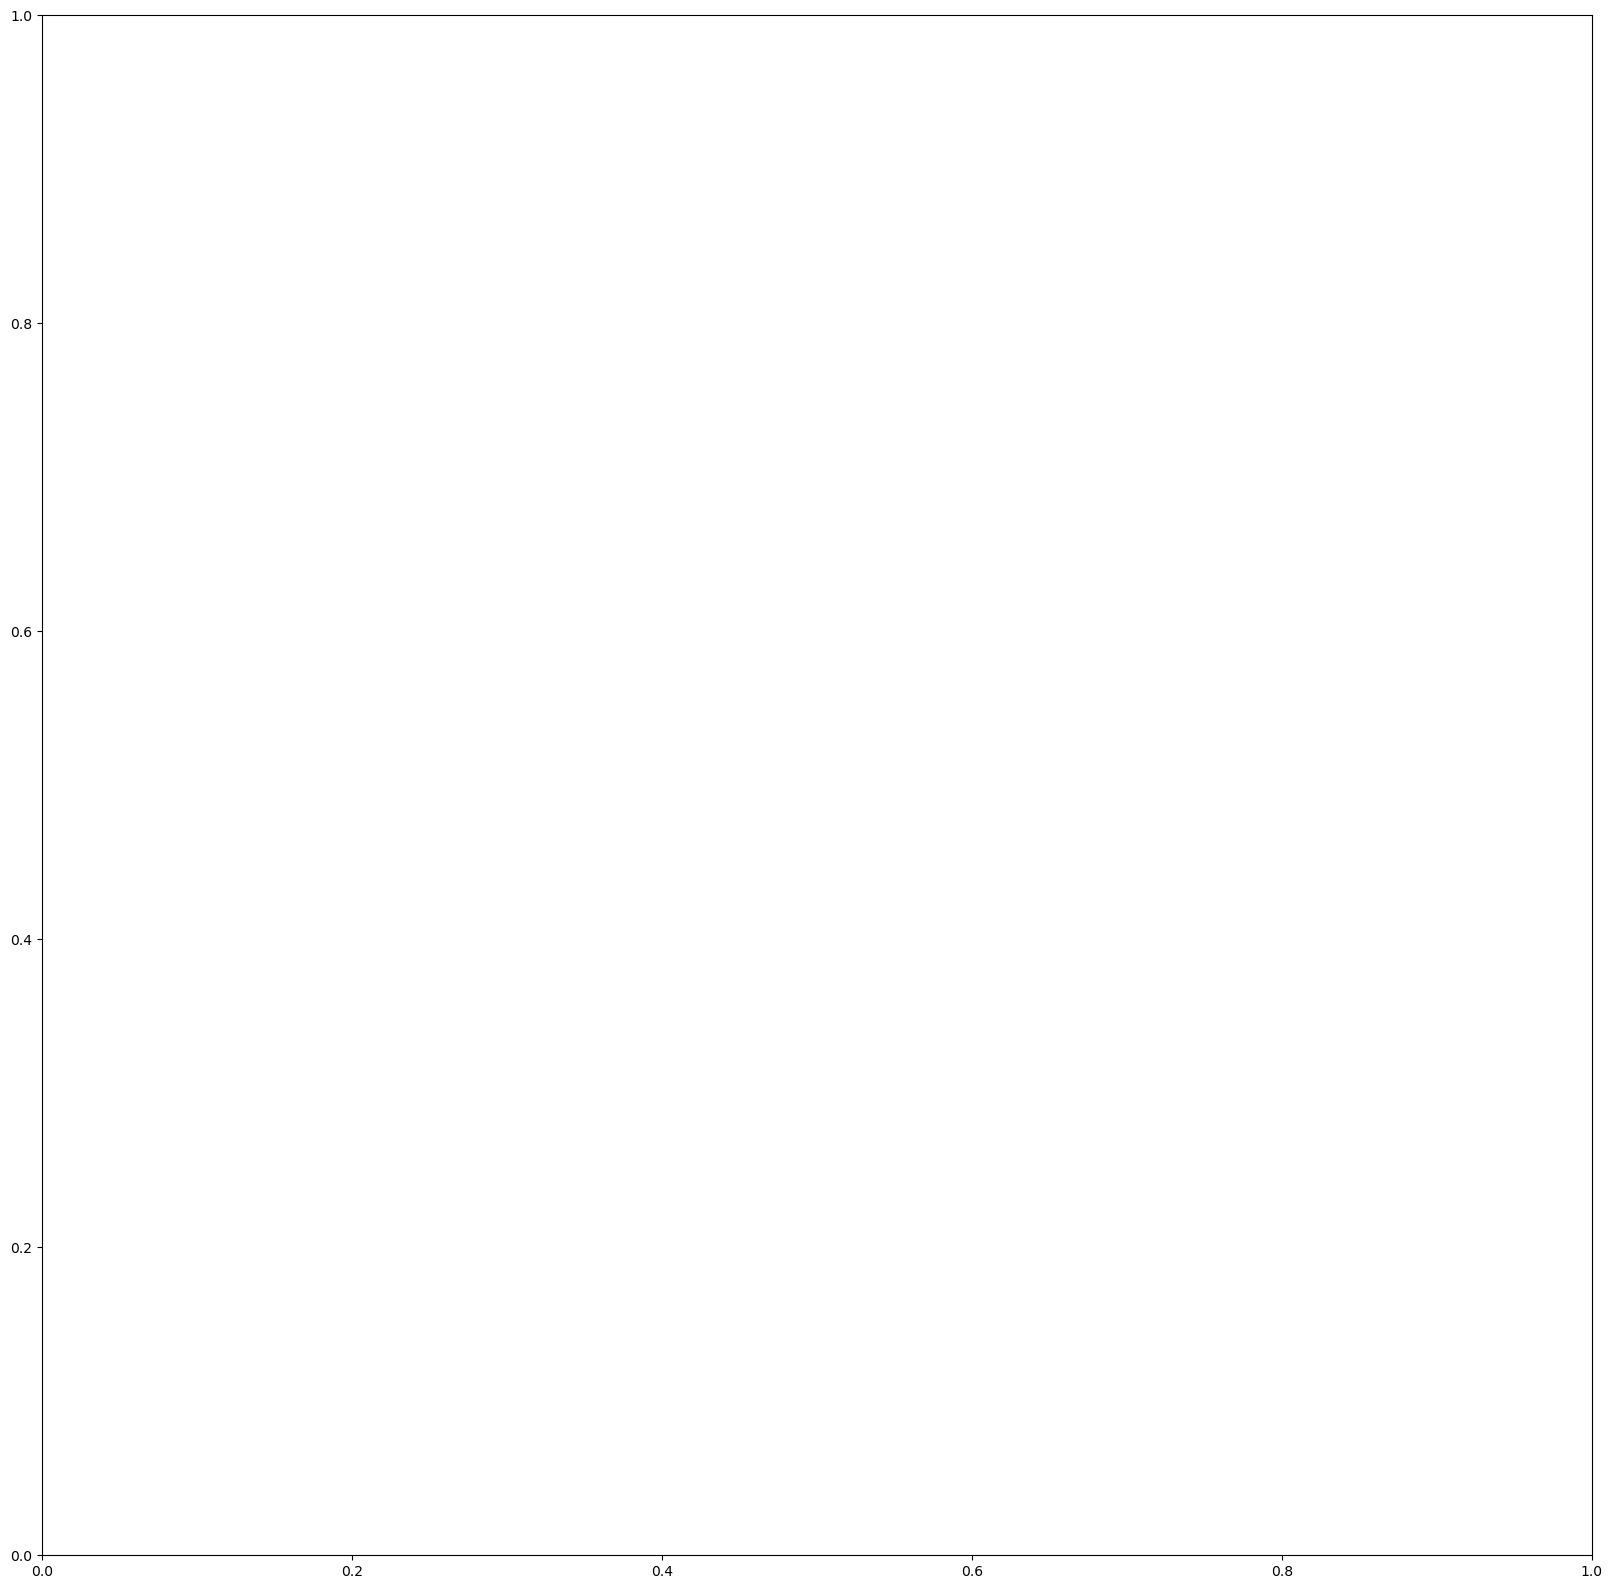

In [135]:
x_train, x_test, y_train, y_test = prepare_train_test_datasets(df_for_modelling, selected_features, prediction_target, dummies_cols)
evaluate_model(RandomForestRegressor(), x_train, y_train, x_test, y_test)

Feature Lp przystanku seems to have a clear, positive trend, suggesting that as the stop order increases (5-15), the delays may become more significant.
The combined plot (right) suggests possible interaction effects between stop order and latitude (stop_lat). Darker regions might indicate hotspots where significant delays are likely. Those features might be correlated, but this shows us exactly which parts of the route have the most impact on the delay,

In [136]:
df_for_modelling.to_csv("df_for_modelling_126_final.csv")

In [8]:
df_for_modelling = pd.read_csv("df_for_modelling_126_final.csv")

Now that we have our model, we can also optimize parameters. We'll use GridSearchCV to find the best parameters for our model.

In [15]:
selected_features = ["Lp przystanku", "Rozkladowy_czas_przyjazdu_is_weekday", "Rozkladowy_czas_przyjazdu_time_of_day", "Rozkladowy_czas_przyjazdu_is_holiday", "stop_lat", "stop_lon", "distance_to_next_stop", "average_delay_last_10_observations", "season"] + selected_weather_features
prediction_target = 'delay'
dummies_cols = ['Rozkladowy_czas_przyjazdu_is_weekday', 'Rozkladowy_czas_przyjazdu_time_of_day', 'Rozkladowy_czas_przyjazdu_is_holiday']
cycle_cols = ["season"]

In [138]:
x_train, x_test, y_train, y_test = prepare_train_test_datasets(df_for_modelling, selected_features, prediction_target, dummies_cols, cycle_cols)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False) 

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100],        
    'max_depth': [None, 10, 30, 40],      
    'min_samples_split': [2, 5, 10],     
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['auto', 'log2', 'sqrt'] 
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  
    cv=3,                              
    n_jobs=-1,                         
    verbose=2                          
)

grid_search.fit(x_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative RMSE):", grid_search.best_score_)

best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\48514\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
147 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\48514\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\48514\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\48514\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 666, in _validate_params
    vali

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score (Negative RMSE): -147.81767668391186


## Evaluation

In all cases we're better than baseline models. Let's see the worst predictions of our model. This will give us some insights on what to improve in the model if we were to continue this project.

In [16]:
x_train, x_test, y_train, y_test = prepare_train_test_datasets(df_for_modelling, selected_features, prediction_target, dummies_cols, cycle_cols)


In [17]:
import shap
print("fitting")
best_model = fit_best_model(RandomForestRegressor(), x_train, y_train)
print("predicting")
predictions = best_model.predict(x_test)
print("explaining")
explainer = shap.TreeExplainer(best_model)
preds_df = {
    'actual_delay': y_test,
    'predicted_delay': predictions,
    'rmse': root_mean_squared_error(y_test, predictions),
    'pred_idx': range(len(predictions))
}
print("worst predictions")

worst_predictions = pd.DataFrame(preds_df).sort_values('rmse', ascending=False).head(10)

fitting
predicting
explaining
worst predictions


In [19]:
worst_predictions_idx = worst_predictions.pred_idx.to_list()
worst_preds_df = x_test.iloc[worst_predictions_idx]
worst_preds_df

Lp przystanku  stop_lat  stop_lon  distance_to_next_stop  \
292144             19  54.36402  18.49174             511.344134   
340833              5  54.38447  18.43184            1311.395262   
340839             15  54.35307  18.49493             497.785918   
340838             14  54.35389  18.49080             283.617177   
340837             13  54.35943  18.49142             617.982454   
340836              8  54.37498  18.46400            2484.419682   
340835              7  54.37716  18.45492             637.997732   
340834              6  54.37852  18.44926             397.726652   
340832              4  54.38647  18.42393             560.049428   
340841             17  54.34964  18.51244            6936.798626   

        average_delay_last_10_observations  season  humidity  tempmax  \
292144                                85.3       2      70.8     74.4   
340833                               115.3       1      87.0     43.0   
340839                               -77.0       1      87.0     43.0   
340838                               -28.4       1      87.0     43.0   
340837                                10.4       1      87.0     43.0   
340836                                43.5       1      87.0     43.0   
340835                                78.8       1      87.0     43.0   
340834                                97.3       1      87.0     43.0   
340832                               151.7       1      87.0     43.0   
340841                               -67.3       1      87.0     43.0   

        tempmin  precip  ...  Rozkladowy_czas_przyjazdu_time_of_day_Afternoon  \
292144     60.5   0.005  ...                                                0   
340833     31.3   0.000  ...                                                0   
340839     31.3   0.000  ...                                                0   
340838     31.3   0.000  ...                                                0   
340837     31.3   0.000  ...                                                0   
340836     31.3   0.000  ...                                                0   
340835     31.3   0.000  ...                                                0   
340834     31.3   0.000  ...                                                0   
340832     31.3   0.000  ...                                                0   
340841     31.3   0.000  ...                                                0   

        Rozkladowy_czas_przyjazdu_time_of_day_Early Morning  \
292144                                                  0     
340833                                                  1     
340839                                                  1     
340838                                                  1     
340837                                                  1     
340836                                                  1     
340835                                                  1     
340834                                                  1     
340832                                                  1     
340841                                                  1     

        Rozkladowy_czas_przyjazdu_time_of_day_Evening  \
292144                                              1   
340833                                              0   
340839                                              0   
340838                                              0   
340837                                              0   
340836                                              0   
340835                                              0   
340834                                              0   
340832                                              0   
340841                                              0   

        Rozkladowy_czas_przyjazdu_time_of_day_Late Evening  \
292144                                                  0    
340833                                                  0    
340839                                                 

In [24]:
worst_predictions

actual_delay  predicted_delay        rmse  pred_idx
292144          75.0            68.99  125.376744         0
340833         -76.0           112.94  125.376744     48689
340839         -76.0           -82.47  125.376744     48695
340838         -45.0            45.85  125.376744     48694
340837         -55.0            23.68  125.376744     48693
340836        -113.0           -21.78  125.376744     48692
340835         -91.0            55.35  125.376744     48691
340834         -83.0            92.64  125.376744     48690
340832         -82.0           134.82  125.376744     48688
340841         -51.0           -65.20  125.376744     48697

It is interesting to see the second prediction. Actually the bus was 76 seconds before scheduled arrival time, but we predicted 68 seconds of delay. This is a costly mistake for our model as we're predicting a delay when there is none. Let's see the SHAP values for this prediction.

In [25]:
shap_values = explainer.shap_values(worst_preds_df.iloc[1])

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, worst_preds_df.iloc[1])

From shap values we learn that what contributed to predicting such a high delay. Red Bars (positive influence): Features that pushed the prediction higher (increasing the predicted outcome).
Blue Bars (negative influence): Features that pulled the prediction lower (decreasing the predicted outcome).
- stop_lat = 54.38: A significant positive contributor.
- Rozkladowy_czas_przyjazdu_time_of_day_Early Morning = 1: Indicates the time of day had a strong positive impact on increasing the target prediction.
- Lp przystanku = 5: This negatively influenced the result. (as we saw the delay is usually higher for higher stop numbers)
- average_delay_last_10_observations = 115.3: The average past delays contributed significantly to reducing the predicted delay. 

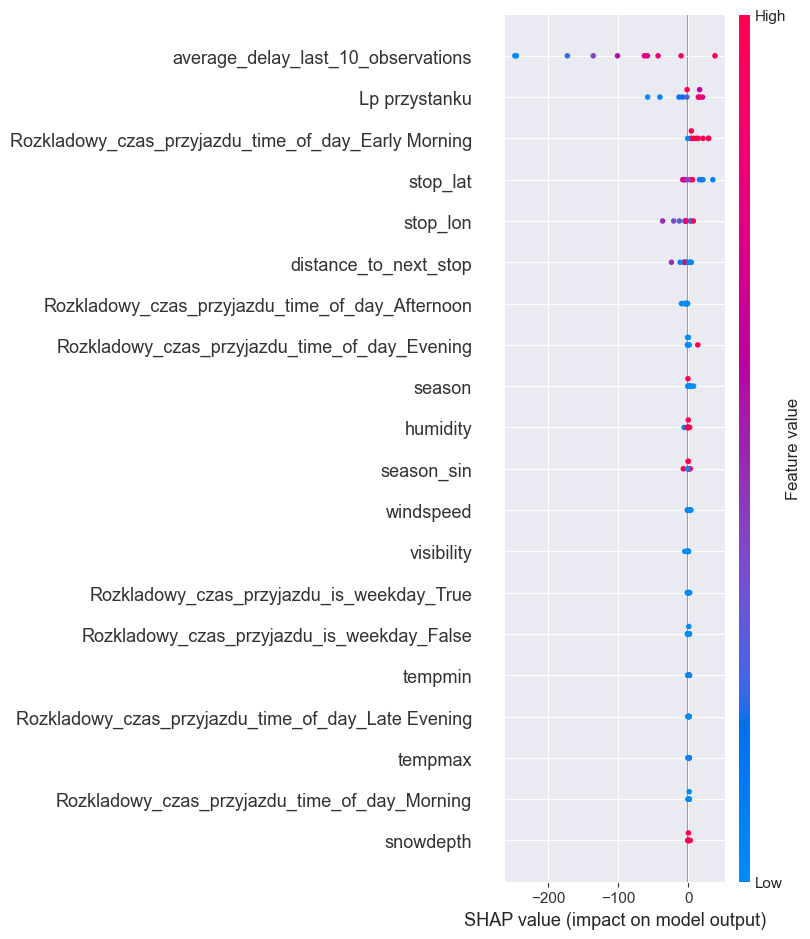

In [27]:
shap_values = explainer.shap_values(worst_preds_df)
shap.summary_plot(shap_values, worst_preds_df)


Most Important Features:

- average_delay_last_10_observations: Strongly drives both positive and negative changes in predictions.
Higher values (pink dots) increase delay predictions.
- Lp przystanku: Positional information seems influential, potentially capturing delay trends along routes. High feature value is highly influential.
- Rozkladowy_czas_przyjazdu_time_of_day_Early Morning: Higher values indicate trips in the early morning, increasing or decreasing delay depending on context.

To further improve the performance of the model, we could:
- analyze the Early Morning samples and see if there are some that skew our predictions.

# Summary
Stages of this project:
1. Data acquisition - we gathered data from the dataset maintainer and weather data from the API as well as stop information from the JSON file.
2. Data exploration - we analyzed the delay distribution, trends, and relationships between features and delay.
3. Data cleaning - we removed duplicates, extreme values, and added stop information.
4. Data preparation - we created new features, added weather data, and prepared the dataset for modelling.
5. Modelling - we trained several models, evaluated them, and chose the best one.
6. Model optimization - we optimized the model parameters using GridSearchCV.
7. Evaluation - we evaluated the model and explained the predictions using PDP plots and SHAP values.

Key insights from this project:
- The average delay is the highest in the evening and the lowest at night.
- The average delay is higher on weekdays, in the evening, and on holidays.
- The highest average delay is for terminal stops.
- Delay grows as the number of stop increases.

Next steps:
- Further analysis of model mistakes and attempts to improve it
- More detailed weather data with hourly breakdown, not just daily
- Extending the analysis to other lines
- Attempt to create a model for multiple lines
- Exploration of variables related to delays in the area and bus traffic
- Choose different metric to penalize the model for predicting delay when there is speedup